

<a id='seccion1'></a>
# **1.Intro**



Los datos pertenecen a las ventas semanales de una cadena de supermercados en la costa este de EEUU. En los datos tenemos unas 10 tiendas distribuidas en tres ciudades (New York, Boston y Philadelphia) con un historico de ventas desde 2011 hasta primer trimestre de 2016.

El objetivo será **predecir las ventas de cada tienda a 4 semanas del presente**.

Los datos son limpios y estructurados, no nos centraremos en hacer un EDA ni profundizar en el preprocesamiento. La idea es centrarse en el modelaje con Prophet de Meta.



**ROAD MAP Y OUTLINE**:


**1. Intro**
- 1.1 Librerias
- 1.2 Agrupacion datos por tienda

**2. Eventos**:
- 2.1 Nuevos eventos
- 2.2 Exploracion datos en tienda de ejemplo

**3. Modelaje con Prophet**
- 3.1 Prophet RAW frecuencia diaria
- 3.2 Resampling semanal: Prophet RAW
- 3.3 Prediccion multitienda

**4. Optimizacion del modelo**
- 4.1 Inclusion de Regresores
- 4.2 Ajuste de hiperparametros
- 4.3 Cross-Validation

**5. Conclusiones**


## **Libraries**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

In [1]:

# Generales
import pandas as pd
import datetime as dt
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Modelaje
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error,r2_score


In [2]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.6 MB/s eta 0:00:00


In [3]:
# Tuneo hiperparametros (importado más abajo, necesaria instalacion de skopt)
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

## División datos por tienda
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Prophet para modelar necesita unicamente dos columnas, el tiempo(ds) y la variable a predecir (y), en nuestro caso el valor de venta.
Por eso necesitaremos dividir nuestra df inicial en 10 subsecuentes dataframes para cada tienda (10 en total)


Los datos ya han sido preprocesados evitando gaps temporales y nulos.

In [4]:
# Dado el ingente tamaño de los datos y para evitar colapso en la RAM ,hemos dividido por tienda y agrupado por dia generando un df para cada tienda

# cargaremos los datos csv a los df ya formateados para prophet con frecuencias diarias


# BOSTON
df_prophet_BOS_1_South_End= pd.read_csv('df_prophet_BOS_1_South_End_fine.csv')
df_prophet_BOS_1_South_End['ds']=pd.to_datetime(df_prophet_BOS_1_South_End['ds'])
df_prophet_BOS_1_South_End.asfreq('D')

df_prophet_BOS_2_Roxbury= pd.read_csv('df_prophet_BOS_2_Roxbury_fine.csv')
df_prophet_BOS_2_Roxbury['ds']=pd.to_datetime(df_prophet_BOS_2_Roxbury['ds'])
df_prophet_BOS_2_Roxbury.asfreq('D')

df_prophet_BOS_3_Back_Bay= pd.read_csv('df_prophet_BOS_3_Back_Bay_fine.csv')
df_prophet_BOS_3_Back_Bay['ds']=pd.to_datetime(df_prophet_BOS_3_Back_Bay['ds'])
df_prophet_BOS_3_Back_Bay.asfreq('D')


# NEW YORK

df_prophet_NYC_1_Greenwich_Village= pd.read_csv('df_prophet_NYC_1_Greenwich_Village_fine.csv')
df_prophet_NYC_1_Greenwich_Village['ds']=pd.to_datetime(df_prophet_NYC_1_Greenwich_Village['ds'])
df_prophet_NYC_1_Greenwich_Village.asfreq('D')


df_prophet_NYC_2_Harlem= pd.read_csv('df_prophet_NYC_2_Harlem_fine.csv')
df_prophet_NYC_2_Harlem['ds']=pd.to_datetime(df_prophet_NYC_2_Harlem['ds'])
df_prophet_NYC_2_Harlem.asfreq('D')

df_prophet_NYC_3_Tribeca= pd.read_csv('df_prophet_NYC_3_Tribeca_fine.csv')
df_prophet_NYC_3_Tribeca['ds']=pd.to_datetime(df_prophet_NYC_3_Tribeca['ds'])
df_prophet_NYC_3_Tribeca.asfreq('D')

df_prophet_NYC_4_Brooklyn= pd.read_csv('df_prophet_NYC_4_Brooklyn_fine.csv')
df_prophet_NYC_4_Brooklyn['ds']=pd.to_datetime(df_prophet_NYC_4_Brooklyn['ds'])
df_prophet_NYC_4_Brooklyn.asfreq('D')


# PHILADELPHIA

df_prophet_PHI_1_Midtown_Village= pd.read_csv('df_prophet_PHI_1_Midtown_Village_fine.csv')
df_prophet_PHI_1_Midtown_Village['ds']=pd.to_datetime(df_prophet_PHI_1_Midtown_Village['ds'])
df_prophet_PHI_1_Midtown_Village.asfreq('D')

df_prophet_PHI_2_Yorktown= pd.read_csv('df_prophet_PHI_2_Yorktown_fine.csv')
df_prophet_PHI_2_Yorktown['ds']=pd.to_datetime(df_prophet_PHI_2_Yorktown['ds'])
df_prophet_PHI_2_Yorktown.asfreq('D')

df_prophet_PHI_3_Queen_Village= pd.read_csv('df_prophet_PHI_3_Queen_Village_fine.csv')
df_prophet_PHI_3_Queen_Village['ds']=pd.to_datetime(df_prophet_PHI_3_Queen_Village['ds'])
df_prophet_PHI_3_Queen_Village.asfreq('D')


# y tambien cargaremos los datos a nivel global para ver las predicciones con prophet
df_global_prophet=pd.read_csv('df_global_prophet_fine.csv')
df_global_prophet['ds']=pd.to_datetime(df_global_prophet['ds'])
df_global_prophet.asfreq('D')


# visualizamos ejemplos
display(df_global_prophet)
display(df_prophet_BOS_1_South_End)



ds            y
0    2011-01-31   70924.5021
1    2011-02-01   74568.1945
2    2011-02-02   57583.2224
3    2011-02-03   85026.2729
4    2011-02-04   84535.5053
...         ...          ...
1906 2016-04-20  139043.5841
1907 2016-04-21  136022.8401
1908 2016-04-22  156581.7461
1909 2016-04-23  191485.1639
1910 2016-04-24  200888.1981

[1911 rows x 2 columns]

ds           y
0    2011-01-31   5577.6946
1    2011-02-01   6574.7755
2    2011-02-02   5308.8069
3    2011-02-03   8272.3707
4    2011-02-04   5429.1306
...         ...         ...
1906 2016-04-20  11040.3130
1907 2016-04-21  10168.9610
1908 2016-04-22  11727.3810
1909 2016-04-23  14010.9656
1910 2016-04-24  16082.8415

[1911 rows x 2 columns]

In [5]:
# crearemos un diccionario para almacenar estas df e ir iterando proximamente con los modelos

dict_tienda_daily= {'South_End_BOS_1': df_prophet_BOS_1_South_End,
                'Roxbury_BOS_2': df_prophet_BOS_2_Roxbury,
                'Back_Bay_BOS_3': df_prophet_BOS_3_Back_Bay,
                'Greenwich_Village_NYC_1': df_prophet_NYC_1_Greenwich_Village,
                'Harlem_NYC_2': df_prophet_NYC_2_Harlem,
                'Tribeca_NYC_3': df_prophet_NYC_3_Tribeca,
                'Brooklyn_NYC_4': df_prophet_NYC_4_Brooklyn,
                'Midtown_Village_PHI_1': df_prophet_PHI_1_Midtown_Village,
                'Yorktown_PHI_2': df_prophet_PHI_2_Yorktown,
                'Queen_Village_PHI_3': df_prophet_PHI_3_Queen_Village,
                'Global sales':df_global_prophet}


<a id='seccion2'></a>
# **2. Eventos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Unas de las ventajas de Prophet respecto a otros modelos de prediccion es su simplicidad y accesibilidad al usuario. Adicionalmente prophet permite modelar utilizando eventos externos para impactarlos sobre la prediccion.

Prophet modela la serie temporal y(t) con tres componentes principales: tendencia (g) , seasonality(s)  y eventos(holiday, h) mas el error (ϵ)

La fórmula general que utiliza es:

y(t)=g(t)+s(t)+h(t)+ϵ

Una de las ventajas de prophet es que no necesitamos procesar los datos temporales de la misma forma tediosa que necesitan los modelos como ARIMA o basados en boosting (XGBoost, CatBoost...) simplemente con una fecha y un valor a predecir Prophet es capaz de funcionar, siempre y cuando lo formateemos adecuadamente.
​


In [6]:
# Prophet funciona mejor con eventos, asi que extraeremos los eventos mas importantes de nuestro csv de eventos.

df_events= pd.read_csv('daily_calendar_with_events.csv')
df_events

date    weekday  weekday_int       d event
0     2011-01-29   Saturday            1     d_1   NaN
1     2011-01-30     Sunday            2     d_2   NaN
2     2011-01-31     Monday            3     d_3   NaN
3     2011-02-01    Tuesday            4     d_4   NaN
4     2011-02-02  Wednesday            5     d_5   NaN
...          ...        ...          ...     ...   ...
1908  2016-04-20  Wednesday            5  d_1909   NaN
1909  2016-04-21   Thursday            6  d_1910   NaN
1910  2016-04-22     Friday            7  d_1911   NaN
1911  2016-04-23   Saturday            1  d_1912   NaN
1912  2016-04-24     Sunday            2  d_1913   NaN

[1913 rows x 5 columns]

In [7]:
# extraemos el df con los eventos filtrados:

df_events.dropna(inplace=True)

# cambiamos las columans para el prophet

df_events.rename(columns={'date':'ds','event':'holiday'},inplace=True)

df_events['ds']=pd.to_datetime(df_events['ds'])

# eliminamos las columnas que no interesan
df_events.drop(columns=['weekday','weekday_int','d'],inplace=True)
df_events

ds         holiday
8    2011-02-06       SuperBowl
184  2011-08-01  Ramadan starts
299  2011-11-24    Thanksgiving
337  2012-01-01         NewYear
372  2012-02-05       SuperBowl
435  2012-04-08          Easter
538  2012-07-20  Ramadan starts
663  2012-11-22    Thanksgiving
703  2013-01-01         NewYear
736  2013-02-03       SuperBowl
792  2013-03-31          Easter
892  2013-07-09  Ramadan starts
1034 2013-11-28    Thanksgiving
1068 2014-01-01         NewYear
1100 2014-02-02       SuperBowl
1177 2014-04-20          Easter
1247 2014-06-29  Ramadan starts
1398 2014-11-27    Thanksgiving
1433 2015-01-01         NewYear
1464 2015-02-01       SuperBowl
1527 2015-04-05          Easter
1601 2015-06-18  Ramadan starts
1762 2015-11-26    Thanksgiving
1798 2016-01-01         NewYear
1835 2016-02-07       SuperBowl
1884 2016-03-27          Easter

## **Nuevos eventos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Como nuestra region es la costa este de EEUU, aparte de los eventos que están dentro de nuestra df_events (Superbowl, Easter, Ramadan...) buscaremos otros eventos tambien importantes basandonos en la cultura norteamericana. Como los datos a predecir se basan en las ventas de una cadena de supermercados, buscaremos situaciones en las que se de un aumento de venta debido a un evento o festividad.


Seleccionaremos los siguientes:
Eventos ya incluidos
- Easter
- Thanksgiving
- New Year
- Superbowl
- Ramadan starts


Eventos comerciales/festivos
- Black Friday
- Halloween
- 4th July, dia de la independencia norteamericana
- San valentín
- Dia de la madre y del padre
- Navidades

Festividades religiosas:
Ya que nuestra df_events incluye Ramadan, añadiremos tambien Hannukah y Diwali, en el caso de NY, existe un 5%, 3% y 2%  de poblacion Judia, Musulmana e Hindi.
- Hannukah: Judia
- Diwali: Hindi
- Eid-al-Fitr: Fin del ramadan, Musulmana.

Otras eventos locales:
- NYC Marathon
- NYC Pride
- Boston Marathon

In [8]:
# Aparte añadiremos otros eventos importantes y fechas que se han producido en las tres ciudades.

eventos = [
    {'fecha': '2011-11-25', 'evento': 'Black Friday'},
    {'fecha': '2012-11-23', 'evento': 'Black Friday'},
    {'fecha': '2013-11-29', 'evento': 'Black Friday'},
    {'fecha': '2014-11-28', 'evento': 'Black Friday'},
    {'fecha': '2015-11-27', 'evento': 'Black Friday'},
    {'fecha': '2016-11-25', 'evento': 'Black Friday'},
    {'fecha': '2017-11-24', 'evento': 'Black Friday'},
    {'fecha': '2011-10-31', 'evento': 'Halloween'},
    {'fecha': '2012-10-31', 'evento': 'Halloween'},
    {'fecha': '2013-10-31', 'evento': 'Halloween'},
    {'fecha': '2014-10-31', 'evento': 'Halloween'},
    {'fecha': '2015-10-31', 'evento': 'Halloween'},
    {'fecha': '2016-10-31', 'evento': 'Halloween'},
    {'fecha': '2017-10-31', 'evento': 'Halloween'},
    {'fecha': '2011-07-04', 'evento': 'Independence Day'},
    {'fecha': '2012-07-04', 'evento': 'Independence Day'},
    {'fecha': '2013-07-04', 'evento': 'Independence Day'},
    {'fecha': '2014-07-04', 'evento': 'Independence Day'},
    {'fecha': '2015-07-04', 'evento': 'Independence Day'},
    {'fecha': '2016-07-04', 'evento': 'Independence Day'},
    {'fecha': '2017-07-04', 'evento': 'Independence Day'},
    {'fecha': '2011-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2012-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2013-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2014-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2015-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2016-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2017-02-14', 'evento': "Valentine's Day"},
    {'fecha': '2011-05-08', 'evento': "Mother's Day"},
    {'fecha': '2012-05-13', 'evento': "Mother's Day"},
    {'fecha': '2013-05-12', 'evento': "Mother's Day"},
    {'fecha': '2014-05-11', 'evento': "Mother's Day"},
    {'fecha': '2015-05-10', 'evento': "Mother's Day"},
    {'fecha': '2016-05-08', 'evento': "Mother's Day"},
    {'fecha': '2017-05-14', 'evento': "Mother's Day"},
    {'fecha': '2011-06-19', 'evento': "Father's Day"},
    {'fecha': '2012-06-17', 'evento': "Father's Day"},
    {'fecha': '2013-06-16', 'evento': "Father's Day"},
    {'fecha': '2014-06-15', 'evento': "Father's Day"},
    {'fecha': '2015-06-21', 'evento': "Father's Day"},
    {'fecha': '2016-06-19', 'evento': "Father's Day"},
    {'fecha': '2017-06-18', 'evento': "Father's Day"},
    {'fecha': '2011-12-25', 'evento': "Christmas"},
    {'fecha': '2012-12-25', 'evento': "Christmas"},
    {'fecha': '2013-12-25', 'evento': "Christmas"},
    {'fecha': '2014-12-25', 'evento': "Christmas"},
    {'fecha': '2015-12-25', 'evento': "Christmas"},
    {'fecha': '2016-12-25', 'evento': "Christmas"},
    {'fecha': '2017-12-25', 'evento': "Christmas"},
    {'fecha': '2011-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2012-11-04', 'evento': 'NYC Marathon'},
    {'fecha': '2013-11-03', 'evento': 'NYC Marathon'},
    {'fecha': '2014-11-02', 'evento': 'NYC Marathon'},
    {'fecha': '2015-11-01', 'evento': 'NYC Marathon'},
    {'fecha': '2016-11-06', 'evento': 'NYC Marathon'},
    {'fecha': '2017-11-05', 'evento': 'NYC Marathon'},
    {'fecha': '2011-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2012-04-16', 'evento': 'Boston Marathon'},
    {'fecha': '2013-04-15', 'evento': 'Boston Marathon'},
    {'fecha': '2014-04-21', 'evento': 'Boston Marathon'},
    {'fecha': '2015-04-20', 'evento': 'Boston Marathon'},
    {'fecha': '2016-04-18', 'evento': 'Boston Marathon'},
    {'fecha': '2017-04-17', 'evento': 'Boston Marathon'},
    {'fecha': '2011-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2012-06-24', 'evento': 'NYC Pride'},
    {'fecha': '2013-06-30', 'evento': 'NYC Pride'},
    {'fecha': '2014-06-29', 'evento': 'NYC Pride'},
    {'fecha': '2015-06-28', 'evento': 'NYC Pride'},
    {'fecha': '2016-06-26', 'evento': 'NYC Pride'},
    {'fecha': '2017-06-25', 'evento': 'NYC Pride'},
    {'fecha': '2011-08-30', 'evento': "Eid al-Fitr"},
    {'fecha': '2012-08-19', 'evento': "Eid al-Fitr"},
    {'fecha': '2013-08-08', 'evento': "Eid al-Fitr"},
    {'fecha': '2014-07-28', 'evento': "Eid al-Fitr"},
    {'fecha': '2015-07-17', 'evento': "Eid al-Fitr"},
    {'fecha': '2016-07-06', 'evento': "Eid al-Fitr"},
    {'fecha': '2017-06-25', 'evento': "Eid al-Fitr"},
    {'fecha': '2011-12-20', 'evento': 'Hanukkah'},
    {'fecha': '2012-12-08', 'evento': 'Hanukkah'},
    {'fecha': '2013-11-27', 'evento': 'Hanukkah'},
    {'fecha': '2014-12-16', 'evento': 'Hanukkah'},
    {'fecha': '2015-12-06', 'evento': 'Hanukkah'},
    {'fecha': '2016-12-24', 'evento': 'Hanukkah'},
    {'fecha': '2017-12-12', 'evento': 'Hanukkah'},
    {'fecha': '2011-10-26', 'evento': 'Diwali'},
    {'fecha': '2012-11-13', 'evento': 'Diwali'},
    {'fecha': '2013-11-03', 'evento': 'Diwali'},
    {'fecha': '2014-10-23', 'evento': 'Diwali'},
    {'fecha': '2015-11-11', 'evento': 'Diwali'},
    {'fecha': '2016-10-30', 'evento': 'Diwali'},
    {'fecha': '2017-10-19', 'evento': 'Diwali'}
]


In [9]:
# y creamos df con los eventos nuevos.

df_new_events= pd.DataFrame(eventos)

# cambiamos columnas para que sean las mismas que para nuestra futura df para prophet ya que el modelo necesita que
# los nombres de las columnas sean 'ds' para el tiempo y 'holiday' para los eventos o vacaciones.
df_new_events.rename(columns={'fecha':'ds','evento':'holiday'},inplace=True)
# y el formato datetime
df_new_events['ds']=pd.to_datetime(df_new_events['ds'])


df_new_events

ds       holiday
0  2011-11-25  Black Friday
1  2012-11-23  Black Friday
2  2013-11-29  Black Friday
3  2014-11-28  Black Friday
4  2015-11-27  Black Friday
..        ...           ...
86 2013-11-03        Diwali
87 2014-10-23        Diwali
88 2015-11-11        Diwali
89 2016-10-30        Diwali
90 2017-10-19        Diwali

[91 rows x 2 columns]

In [10]:
# concatenamos las dos dataframes

df_events = pd.concat([df_events, df_new_events], ignore_index=True)
# y ya tendriamos nuestra df con los todos los eventos a incluir en el modelo Prophet.
df_events

ds         holiday
0   2011-02-06       SuperBowl
1   2011-08-01  Ramadan starts
2   2011-11-24    Thanksgiving
3   2012-01-01         NewYear
4   2012-02-05       SuperBowl
..         ...             ...
112 2013-11-03          Diwali
113 2014-10-23          Diwali
114 2015-11-11          Diwali
115 2016-10-30          Diwali
116 2017-10-19          Diwali

[117 rows x 2 columns]

## Exploracion datos tienda ejemplo
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Tomaremos una tienda en particular para explorar los datos e inspeccionar en busca de patrones, tendencias o cualquier insight que nos pueda ser de utilidad para aplicar al modelo

<Axes: xlabel='ds', ylabel='y'>

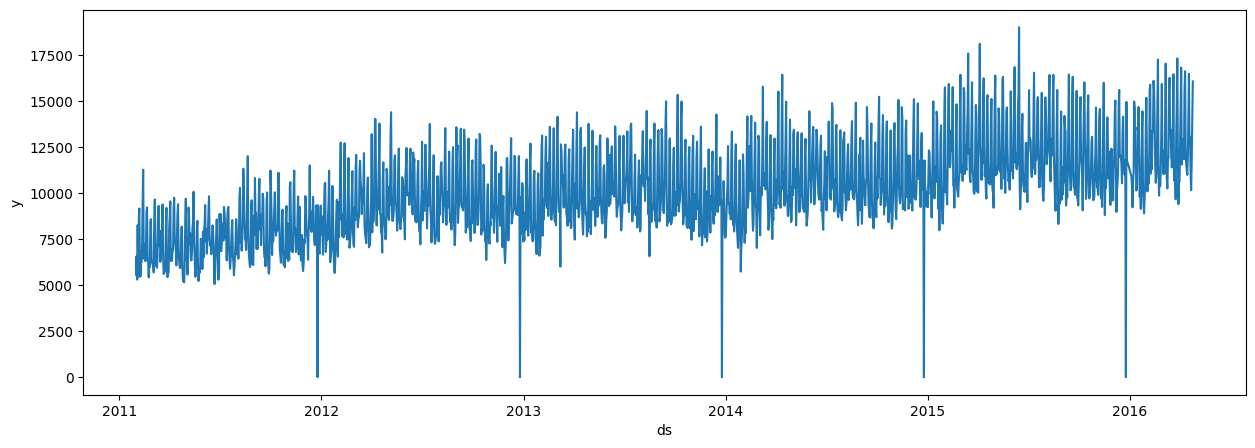

In [11]:
# vamos a representar graficamente las ventas a lo largo del tiempo de la tienda de South_End (Boston).
plt.figure(figsize=(15, 5))


sns.lineplot(data=df_prophet_BOS_1_South_End,x='ds',y='y')

<Axes: xlabel='ds', ylabel='y'>

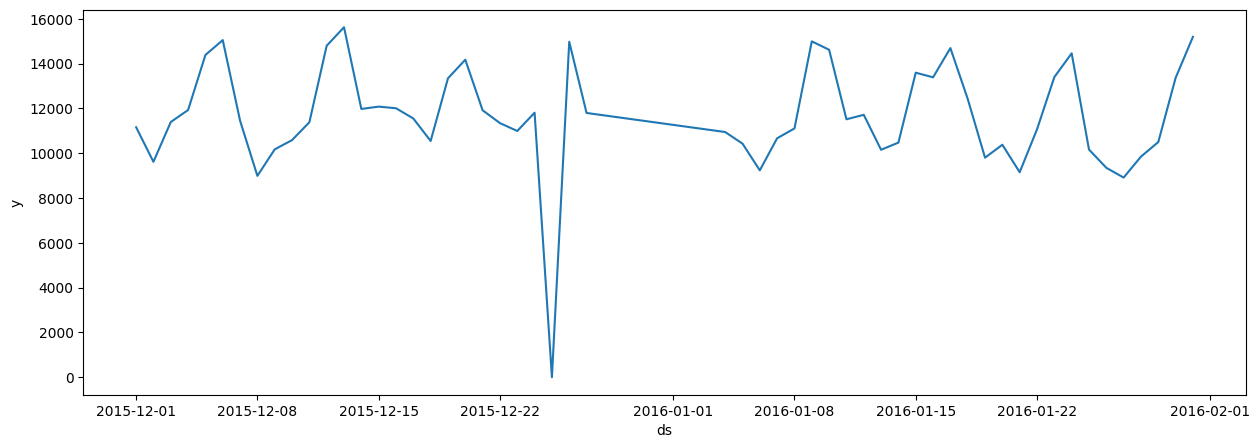

In [12]:
# visualizamos en concreto los meses de diciembre 2015 y enero 2016 que parece que hay algo raro

plt.figure(figsize=(15, 5))
sns.lineplot(data= df_prophet_BOS_1_South_End[(df_prophet_BOS_1_South_End['ds'] >= '2015-12-01') & (df_prophet_BOS_1_South_End['ds'] <= '2016-01-31')],x='ds',y='y')


# vemos que para el 10 de enero de 2016 existe un descenso en ventas considerable. No se si podria deberse a una tormenta invernal

# Tras una busqueda en internet vemos que en enero de 2016 fue el mes en el que ocurrió una gran tormenta de nieve en Estados Unidos (Supertormenta Jonas) , afectando principalmente a la región
# del Atlántico Medio y el Noreste, incluyendo ciudades como Washington D.C., Filadelfia y Nueva York con 1-2.5 pies (12-30 pulgadas) de nieve​ (https://en.wikipedia.org/wiki/January_2016_United_States_blizzard)​.


# he revisado en NY y pasa mas de lo mismo, asi que podria tener sentido. Añadimos el evento

In [13]:
# Verificamos si hay algun gap temporal en esa linea recta
df_prophet_BOS_1_South_End.query(' "2015-12-28" <= ds <= "2016-01-03" ')

# confirmamos que los datos son continuos

ds             y
1792 2015-12-28  11689.261937
1793 2015-12-29  11582.876375
1794 2015-12-30  11476.490813
1795 2015-12-31  11370.105250
1796 2016-01-01  11263.719688
1797 2016-01-02  11157.334125
1798 2016-01-03  11050.948562

In [14]:
# en los ultimos dias de diciembre veo algo raro, vamos a comprobar si hay algun patron de missingsen esos dias a lo largo de los df


# iteramos a lo largo de todas nuestras df almacenadas en el diccionario
for clave in dict_tienda_daily:
  df_tienda= dict_tienda_daily[clave]
  all_dates = pd.date_range(start=df_tienda ['ds'].min(), end=df_tienda ['ds'].max(), freq='D')
  missing_dates = all_dates.difference(df_tienda ['ds'])

  if not missing_dates.empty:
    print("Faltan las siguientes fechas:", missing_dates)
  else:
    print("No faltan fechas. Los datos son continuos.")


No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.
No faltan fechas. Los datos son continuos.



<a id='seccion3'></a>
# **3. Modelaje con Prophet**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Una vez que ya tenemos las df independientes de cada tienda, los eventos correctamente asignado y todo ello siguiendo el formato necesario para prophet (columnas correctamente nombradas, fecha en datetime, ausencia de gaps temporales...) vamos a pasar al modelaje.

Para esta seccion definiremos una funcion que integre todas las df de cada tienda y modele de forma individual las ventas de cada una.

Pero antes de nada, para poder comparar posteriormente el efecto de los eventos, tiraremos en bruto un primer modelo de prophet.




## **Prophet raw frecuencia diaria**

In [15]:
# tiramos un primer modelo a nivel diario sin ajustar para nuestra tienda de ejempo (South End)

# Creamos el modelo
model_raw = Prophet()

# Ajustamos el modelo
model_raw.fit(df_prophet_BOS_1_South_End)

# Creamos un dataframe con las fechas futuras, en nuestro caso como tenemos las ventass por dia con un horizonte de prediccion de un mes
future = model_raw.make_future_dataframe(periods=30 , freq='D')

# Realizamos la prediccion
df_pred_BOS_1_South_End = model_raw.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3bqrq6yt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5fza7fe1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8529', 'data', 'file=/tmp/tmpxxnatxx7/3bqrq6yt.json', 'init=/tmp/tmpxxnatxx7/5fza7fe1.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelm7cdqqv2/prophet_model-20240416172544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'South End -Boston(1) - MAPE: 65740618031778824.00%, R2: 0.79')

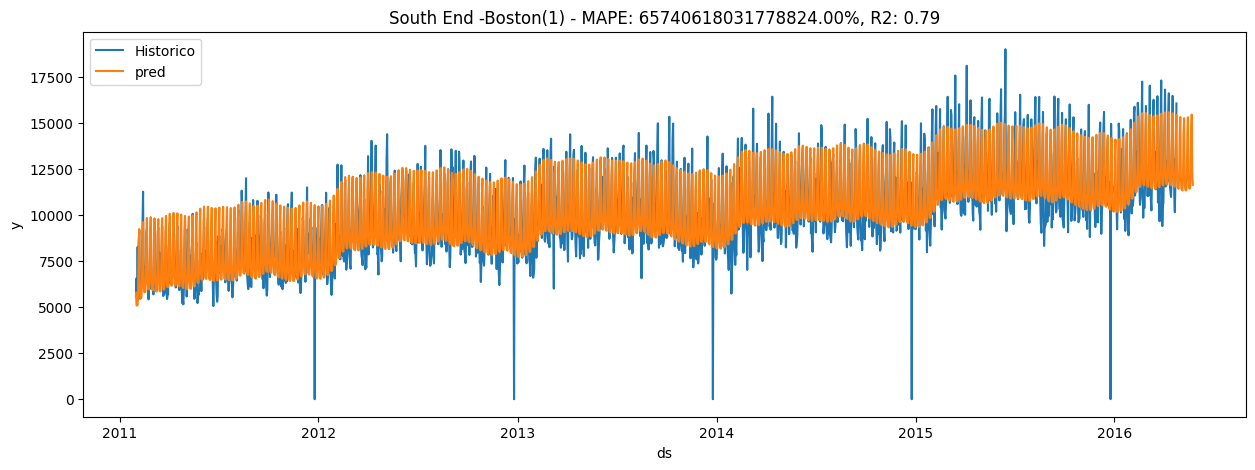

In [16]:
# representamos la prediccion respecto a los datos reales

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_BOS_1_South_End,x='ds',y='y',label='Historico')

sns.lineplot(data=df_pred_BOS_1_South_End,x='ds',y='yhat',label='pred')

# Para calcular el MAPE necesitamos filtrar la prediccion a las fechas presentes en el historico
df_pred_filtered = df_pred_BOS_1_South_End[df_pred_BOS_1_South_End['ds'].isin(df_prophet_BOS_1_South_End['ds'])]
y_pred = df_pred_filtered['yhat']
y_true = df_prophet_BOS_1_South_End['y']

# Calculamos el MAPE y R2
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Añadimos el título con la tienda y metricas
plt.title(f'South End -Boston(1) - MAPE: {mape:.2f}%, R2: {r2:.2f}')

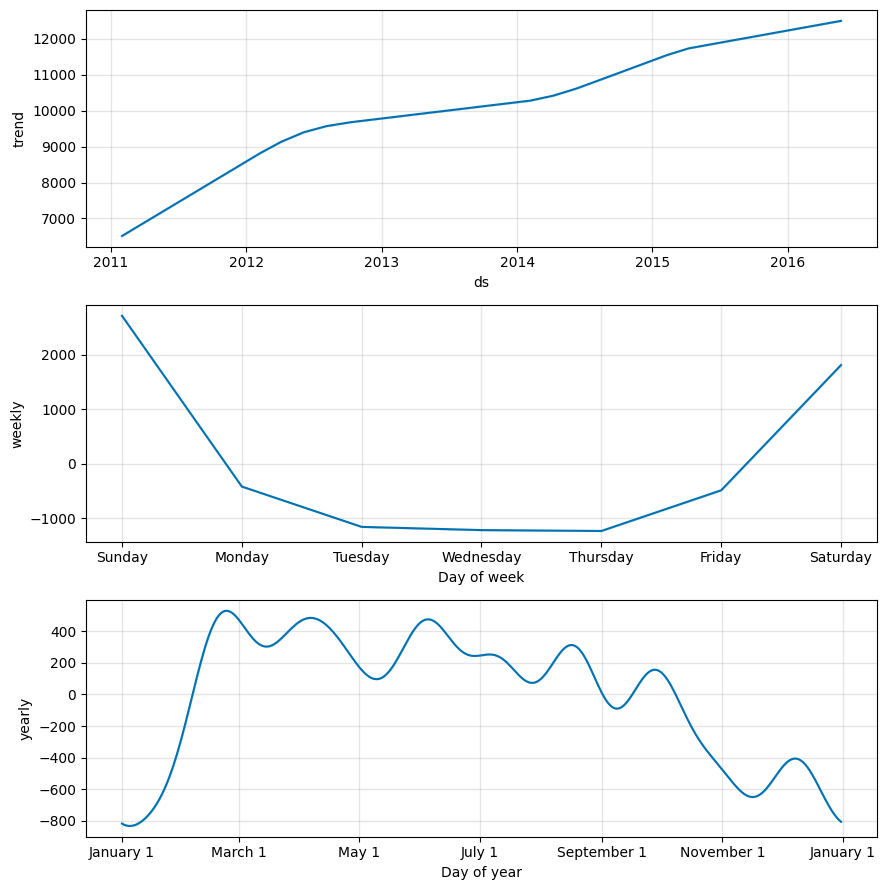

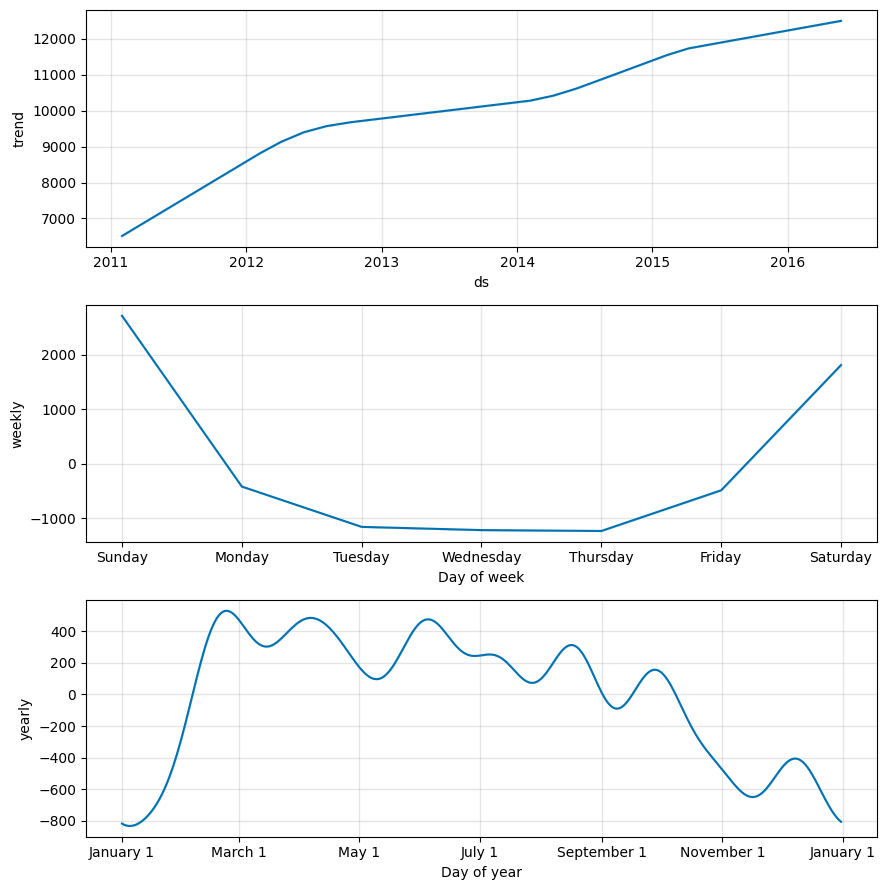

In [17]:
# y visualizamos la descomposicion temporal

model_raw.plot_components(df_pred_BOS_1_South_End)


Comentario descomposicion temporal.

A modo de insight puedo constatar que se compra mas hacia el fin de semana que a lo largo de la semana. Adicionalmente observo una serie de estacionalidades mensuales que llaman mi atencion, las compras son mas acuciadas en los dias medios del mes (12-17).

A nivel anual observo que hay meses donde las ventas caen (Enero y Diciembre).

## **Resampling a nivel semanal**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

A nivel diario vemos que hay mucho ruido en la prediccion y que el modelo overfittea mucho.

Vamos a resamplear los datos para obtenerlos a nivel semanal y tirar el mismo modelo.

Los datos a nivel diario los utilizaremos más tarde para añadir regresores que aumenten permitan aumentar las metricas (mayor granuralidad)



In [18]:
# cambiamos a nivel semanal los df.

# BOSTON
# South End
df_prophet_week_BOS_1_South_End= df_prophet_BOS_1_South_End.copy()
df_prophet_week_BOS_1_South_End.set_index('ds',inplace=True)
df_prophet_week_BOS_1_South_End= df_prophet_week_BOS_1_South_End.resample('W').sum()
df_prophet_week_BOS_1_South_End.reset_index(inplace=True)
# Roxbury
df_prophet_week_BOS_2_Roxbury= df_prophet_BOS_2_Roxbury.copy()
df_prophet_week_BOS_2_Roxbury.set_index('ds',inplace=True)
df_prophet_week_BOS_2_Roxbury= df_prophet_week_BOS_2_Roxbury.resample('W').sum()
df_prophet_week_BOS_2_Roxbury.reset_index(inplace=True)
# Back Bay
df_prophet_week_BOS_3_Back_Bay= df_prophet_BOS_3_Back_Bay.copy()
df_prophet_week_BOS_3_Back_Bay.set_index('ds',inplace=True)
df_prophet_week_BOS_3_Back_Bay= df_prophet_week_BOS_3_Back_Bay.resample('W').sum()
df_prophet_week_BOS_3_Back_Bay.reset_index(inplace=True)


# NEW YORK
# Greenwich Village
df_prophet_week_NYC_1_Greenwich_Village= df_prophet_NYC_1_Greenwich_Village.copy()
df_prophet_week_NYC_1_Greenwich_Village.set_index('ds',inplace=True)
df_prophet_week_NYC_1_Greenwich_Village= df_prophet_week_NYC_1_Greenwich_Village.resample('W').sum()
df_prophet_week_NYC_1_Greenwich_Village.reset_index(inplace=True)
# Harlem
df_prophet_week_NYC_2_Harlem= df_prophet_NYC_2_Harlem.copy()
df_prophet_week_NYC_2_Harlem.set_index('ds',inplace=True)
df_prophet_week_NYC_2_Harlem= df_prophet_week_NYC_2_Harlem.resample('W').sum()
df_prophet_week_NYC_2_Harlem.reset_index(inplace=True)
# Tribeca
df_prophet_week_NYC_3_Tribeca= df_prophet_NYC_3_Tribeca.copy()
df_prophet_week_NYC_3_Tribeca.set_index('ds',inplace=True)
df_prophet_week_NYC_3_Tribeca= df_prophet_week_NYC_3_Tribeca.resample('W').sum()
df_prophet_week_NYC_3_Tribeca.reset_index(inplace=True)
# Brooklyn
df_prophet_week_NYC_4_Brooklyn= df_prophet_NYC_4_Brooklyn.copy()
df_prophet_week_NYC_4_Brooklyn.set_index('ds',inplace=True)
df_prophet_week_NYC_4_Brooklyn= df_prophet_week_NYC_4_Brooklyn.resample('W').sum()
df_prophet_week_NYC_4_Brooklyn.reset_index(inplace=True)

# PHILADELPHIA
# Midtown Village
df_prophet_week_PHI_1_Midtown_Village= df_prophet_PHI_1_Midtown_Village.copy()
df_prophet_week_PHI_1_Midtown_Village.set_index('ds',inplace=True)
df_prophet_week_PHI_1_Midtown_Village= df_prophet_week_PHI_1_Midtown_Village.resample('W').sum()
df_prophet_week_PHI_1_Midtown_Village.reset_index(inplace=True)
# Yorktown
df_prophet_week_PHI_2_Yorktown= df_prophet_PHI_2_Yorktown.copy()
df_prophet_week_PHI_2_Yorktown.set_index('ds',inplace=True)
df_prophet_week_PHI_2_Yorktown= df_prophet_week_PHI_2_Yorktown.resample('W').sum()
df_prophet_week_PHI_2_Yorktown.reset_index(inplace=True)
# Queen Village
df_prophet_week_PHI_3_Queen_Village= df_prophet_PHI_3_Queen_Village.copy()
df_prophet_week_PHI_3_Queen_Village.set_index('ds',inplace=True)
df_prophet_week_PHI_3_Queen_Village= df_prophet_week_PHI_3_Queen_Village.resample('W').sum()
df_prophet_week_PHI_3_Queen_Village.reset_index(inplace=True)


# GLOBAL
df_prophet_week_global= df_global_prophet.copy()
df_prophet_week_global.set_index('ds',inplace=True)
df_prophet_week_global= df_prophet_week_global.resample('W').sum()
df_prophet_week_global.reset_index(inplace=True)



In [19]:
# y los almacenamos en un diccionario a nivel semanal para operar con ellos facilmente.

dict_tienda_weekly= {'South_End_BOS_1_weekly': df_prophet_week_BOS_1_South_End,
                'Roxbury_BOS_2_weekly': df_prophet_week_BOS_2_Roxbury,
                'Back_Bay_BOS_3_weekly': df_prophet_week_BOS_3_Back_Bay,
                'Greenwich_Village_NYC_1_weekly': df_prophet_week_NYC_1_Greenwich_Village,
                'Harlem_NYC_2_weekly': df_prophet_week_NYC_2_Harlem,
                'Tribeca_NYC_3_weekly': df_prophet_week_NYC_3_Tribeca,
                'Brooklyn_NYC_4_weekly': df_prophet_week_NYC_4_Brooklyn,
                'Midtown_Village_PHI_1_weekly': df_prophet_week_PHI_1_Midtown_Village,
                'Yorktown_PHI_2_weekly': df_prophet_week_PHI_2_Yorktown,
                'Queen_Village_PHI_3_weekly': df_prophet_week_PHI_3_Queen_Village,
                'Global sales_weekly':df_prophet_week_global}

In [20]:
df_prophet_week_BOS_1_South_End

ds           y
0   2011-02-06  48892.7164
1   2011-02-13  52513.8213
2   2011-02-20  51784.1312
3   2011-02-27  47537.8775
4   2011-03-06  49005.6250
..         ...         ...
268 2016-03-27  87481.6510
269 2016-04-03  87203.6595
270 2016-04-10  93249.7836
271 2016-04-17  89172.1989
272 2016-04-24  88732.8693

[273 rows x 2 columns]

### Modelaje raw prophet frecuencia semanal


In [21]:
# tiramos el modelo usando la tienda de ejemplo BOS-1

# Creamos el modelo
model_raw_week = Prophet()

# Ajustamos el modelo
model_raw_week.fit(df_prophet_week_BOS_1_South_End)

# Creamos un dataframe con las fechas futuras, en nuestro caso como tenemos las ventass p
future = model_raw_week.make_future_dataframe(periods=24 , freq='W')

# Realizamos la prediccion
df_pred_week_BOS_1_South_End = model_raw_week.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/v_xwcxex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mwh9topq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73867', 'data', 'file=/tmp/tmpxxnatxx7/v_xwcxex.json', 'init=/tmp/tmpxxnatxx7/mwh9topq.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model8z29vao9/prophet_model-20240416172548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


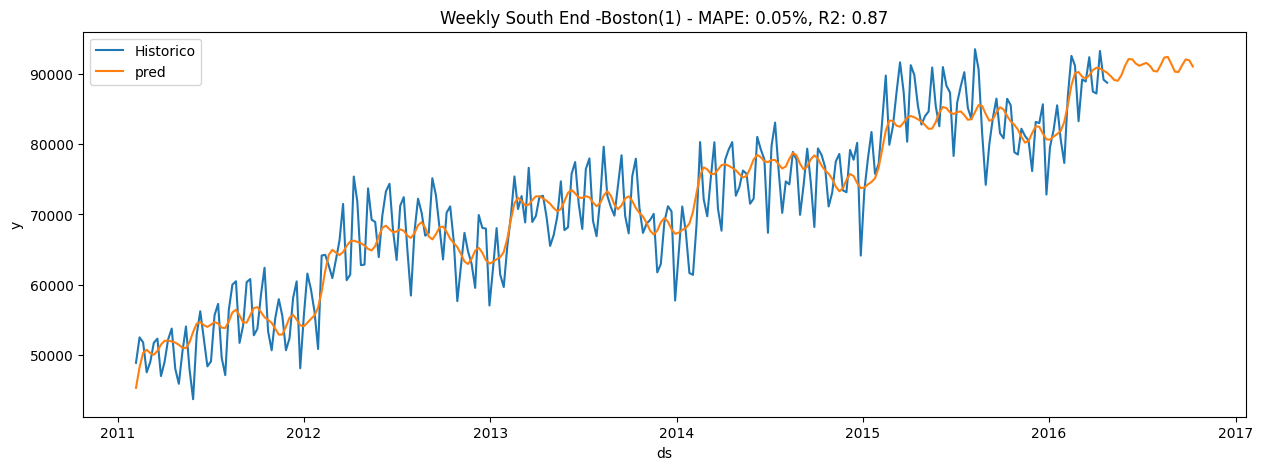

In [22]:
# representamos la prediccion respecto a los datos reales

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_prophet_week_BOS_1_South_End,x='ds',y='y',label='Historico')

sns.lineplot(data=df_pred_week_BOS_1_South_End,x='ds',y='yhat',label='pred')

# Para calcular el MAPE necesitamos filtrar la prediccion a las fechas presentes en el historico
df_pred_filtered_week = df_pred_week_BOS_1_South_End[df_pred_week_BOS_1_South_End['ds'].isin(df_prophet_week_BOS_1_South_End['ds'])]
y_pred_week = df_pred_filtered_week['yhat']
y_true_week = df_prophet_week_BOS_1_South_End['y']

# Calculamos el MAPE y R2
mape_week = mean_absolute_percentage_error(y_true_week, y_pred_week)
r2_week = r2_score(y_true_week, y_pred_week)

# Añadimos el título con la tienda y metricas
plt.title(f'Weekly South End -Boston(1) - MAPE: {mape_week:.2f}%, R2: {r2_week:.2f}')
# Guardar las predicciones para compaar mas adelante
Prophet_RAW_BOS_1_predictions= df_pred_week_BOS_1_South_End[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(df_prophet_week_BOS_1_South_End, on='ds', how='left')

In [23]:

# iteramos a lo largo de todas nuestras df almacenadas en el diccionario

df_tienda= df_prophet_BOS_1_South_End
all_dates = pd.date_range(start=df_tienda ['ds'].min(), end=df_tienda ['ds'].max(), freq='D')
missing_dates = all_dates.difference(df_tienda ['ds'])

if not missing_dates.empty:
  print("Faltan las siguientes fechas:", missing_dates)
else:
  print("No faltan fechas. Los datos son continuos.")



No faltan fechas. Los datos son continuos.


Como hemos podido comprobar las predicciones son mas precisas a nivel semanal que a nivel diario que genera mucho ruido. Sin embargo a nivel semanal no captura los picos maximos y minimos.

El MAPE semanal respecto al diario mejora mucho, pero simplemente porque semanalmente suavizamos los outliers que generan ese descontrol del MAPE.

Igualmente son muy buenas metricas para un modelo RAW.

Ahora añadiremos los eventos y otros aspectos como regresores que puedan mejorar la prediccion.

Pasemos a seguir con la funcion que englobe todas las tiendas y modele predicciones.

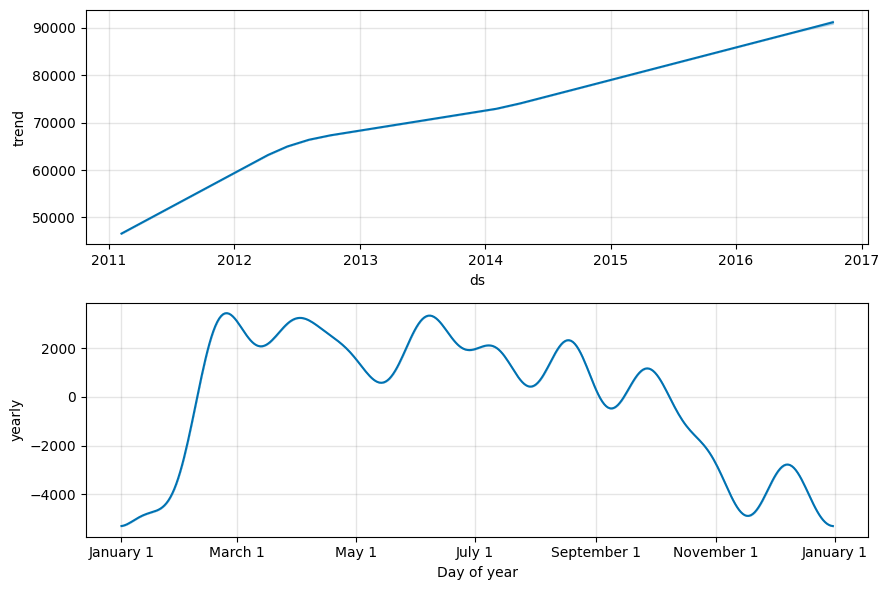

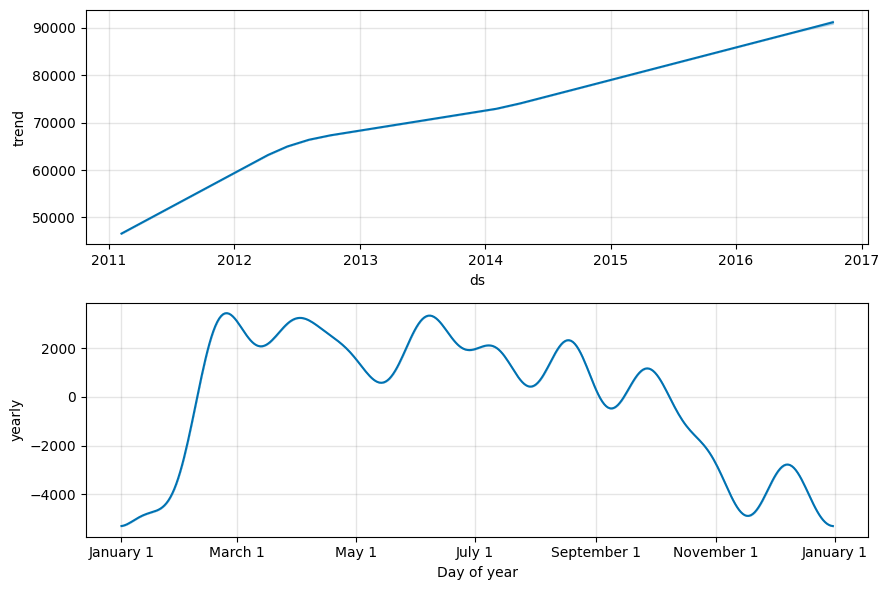

In [24]:
# visualizamos la descomposicion temporal a nivel semanal
model_raw_week.plot_components(df_pred_week_BOS_1_South_End)

Vemos que las descomposiciones temporales de ambas dataframes son identicas. Podemos seguir.

## **Prediccion multitienda - Creación funcion prediccion prophet**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Como la idea es hacer predicciones pero tambien ir iterando con nuevos parametros y ajustar lo que consideremos, crearemos una funcion que nos permita repetir, visualizar y almacenar resultados de cara a tomar decisiones en un futuro.

In [25]:
# creamos una funcion que nos permita hacer las predicciones con prophet por cada tienda independientemente y podamos volver a ejecutarla mas
# tarde de cara al deploy en MLOps (se pueda actualizar con nuevos datos)


'''
Documentacion funcion prophet_store_prediction(dict_tienda, df_events, periods_weeks):

Esta función ajusta un modelo de Prophet para cada tienda contenida en el diccionario dict_tienda,
teniendo en cuenta eventos especiales (df_events) y haciendo predicciones para un número definido
de semanas en el futuro (periods_weeks).

Las predicciones, se visualizan en subplots para facilitar la comparación entre tiendas. Además, se calcula el MAPE
y el R2 para evaluar la precisión de las predicciones en el conjunto de datos históricos.

Finalmente, se retorna un DataFrame con las predicciones futuras, tendencias y valores históricos para cada tienda.

Parámetros:
    - dict_tienda_weekly (dict): Diccionario con nombres de tiendas como claves y DataFrames como valores. Cada DataFrame debe tener columnas 'ds' y 'y'. los datos son semanales

    - df_events (DataFrame): DataFrame de eventos especiales que pueden afectar las predicciones, con columnas 'holiday' y 'ds'.
    - periods_weeks (int): Número de semanas hacia el futuro para generar predicciones.

Devuelve:
    - df_predicciones_prophet (DataFrame): DataFrame con predicciones futuras, tendencias, y valores históricos para todas las tiendas.

'''



def prophet_store_prediction(dict_tienda_weekly, df_events, periods_weeks):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda_weekly.items()):

        # Ajustamos ciertos parametros importantes, incluyendo nuestro df_events. Tras Iterar funciona mucho mejor seasonality_mode='multiplicative'
        model= Prophet(holidays=df_events,
                        seasonality_mode='multiplicative', changepoint_prior_scale=0.10,changepoint_range=0.8,
                        seasonality_prior_scale=10, holidays_prior_scale=10, interval_width=0.95)

        # Añadimos las vacaciones de dicho pais
        # model.add_country_holidays(country_name='US')

        model.fit(df_tienda)
        future = model.make_future_dataframe(periods=periods_weeks,freq='W') # Asumiendo periods_weeks se da en semanas
        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/tajxvzxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/nimat4qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84418', 'data', 'file=/tmp/tmpxxnatxx7/tajxvzxk.json', 'init=/tmp/tmpxxnatxx7/nimat4qz.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelqvs6t21h/prophet_model-20240416172550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:25:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:25:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

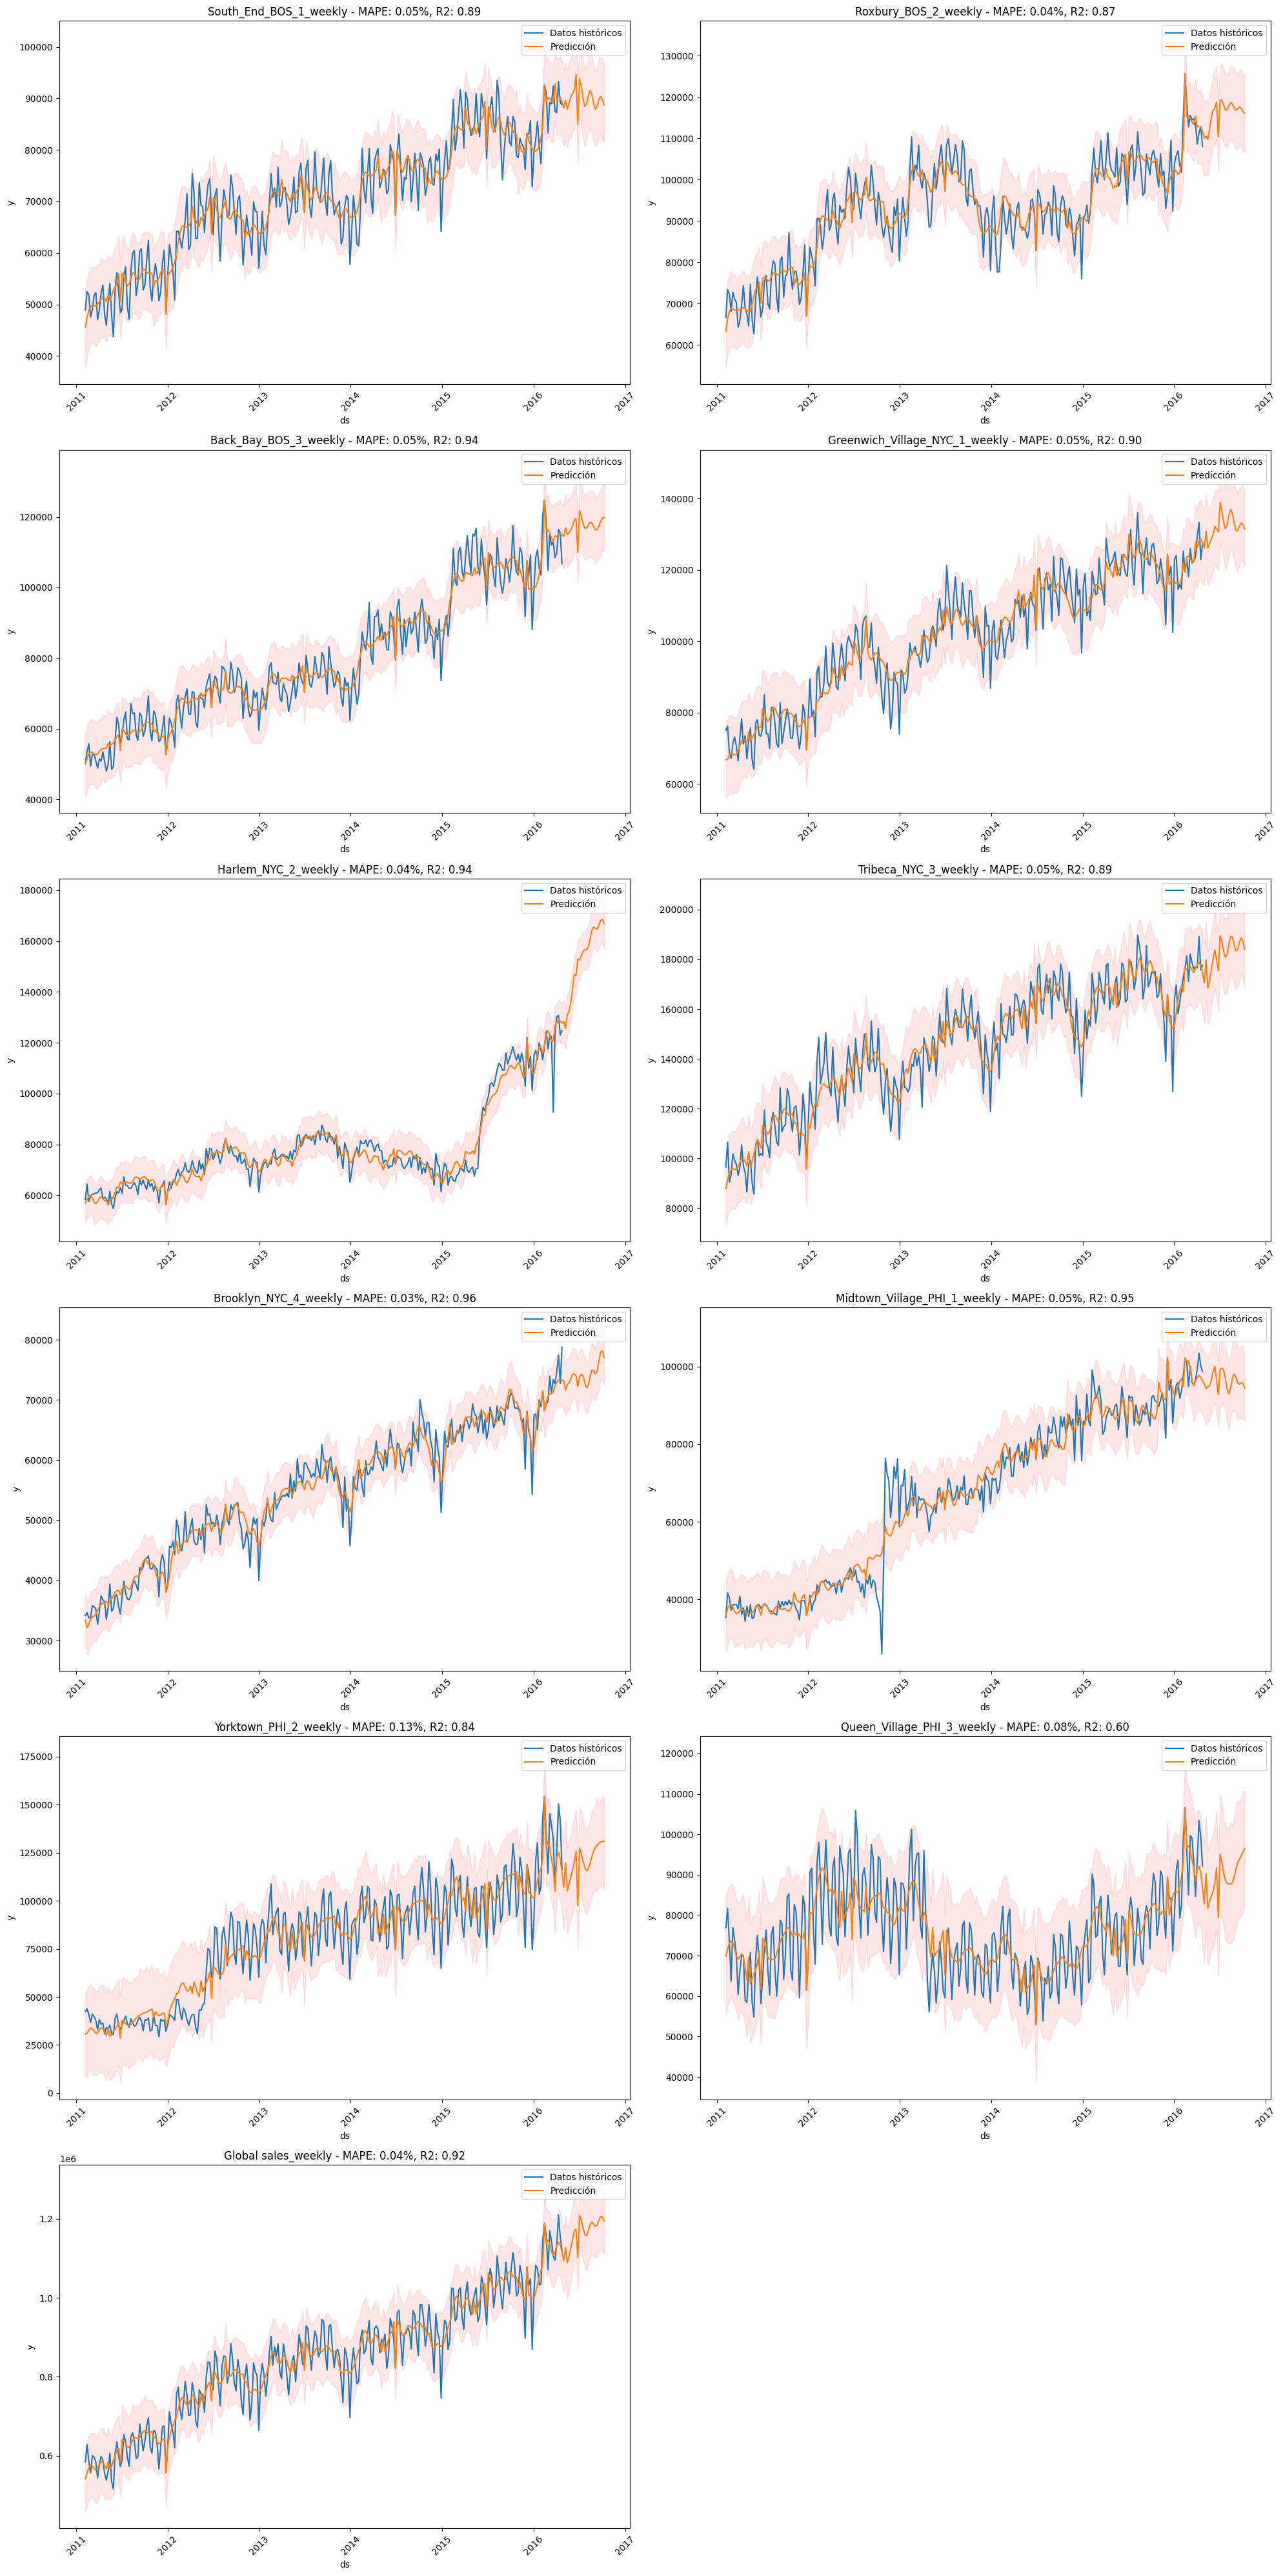

ds                   store          yhat         trend  \
0    2011-02-06  South_End_BOS_1_weekly  4.560210e+04  4.667824e+04   
1    2011-02-13  South_End_BOS_1_weekly  4.742468e+04  4.696309e+04   
2    2011-02-20  South_End_BOS_1_weekly  4.882610e+04  4.724793e+04   
3    2011-02-27  South_End_BOS_1_weekly  4.960054e+04  4.753277e+04   
4    2011-03-06  South_End_BOS_1_weekly  4.978330e+04  4.781761e+04   
...         ...                     ...           ...           ...   
3262 2016-09-11     Global sales_weekly  1.184159e+06  1.168415e+06   
3263 2016-09-18     Global sales_weekly  1.196107e+06  1.171026e+06   
3264 2016-09-25     Global sales_weekly  1.205844e+06  1.173637e+06   
3265 2016-10-02     Global sales_weekly  1.204380e+06  1.176249e+06   
3266 2016-10-09     Global sales_weekly  1.194825e+06  1.178860e+06   

        yhat_lower    yhat_upper           y  
0     3.772747e+04  5.308187e+04  48892.7164  
1     3.989337e+04  5.480867e+04  52513.8213  
2     4.145179e+04  5.633461e+04  51784.1312  
3     4.223301e+04  5.712952e+04  47537.8775  
4     4.250707e+04  5.726709e+04  49005.6250  
...            ...           ...         ...  
3262  1.102315e+06  1.269175e+06         NaN  
3263  1.115096e+06  1.282016e+06         NaN  
3264  1.122068e+06  1.290731e+06         NaN  
3265  1.119516e+06  1.294820e+06         NaN  
3266  1.110937e+06  1.284190e+06         NaN  

[3267 rows x 7 columns]

In [26]:
# llamamos a la funcion creada y almacenamos resultados en un df.
df_predicciones_prophet = prophet_store_prediction(dict_tienda_weekly, df_events, 24)
df_predicciones_prophet



<a id='seccion4'></a>
# **4. Optimizacion del modelo**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

En este apartado trataremos de mejorar las metricas y robusted del modelo a través de diferentes procesos.

Estamos utilizando el MAPE(Mean average percentage error) como metrica para cuantificar el error ya que se interpreta más facil. Esta metrica no podriamos usarla si tuvieramos valores 0 ya que los valores se disparan (por lo de ser un porcentaje).

Para mejorar el MAPE de nuestro modelo anterior, vamos a consideras las siguientes estrategias de ajuste y optimización:


1. **Inclusión de Regresores Adicionales** evaluaremos si podriamos capturar mejor evaluando si existe un patron de compra a lo largo del mes, por ejemplo, si la gente hace la compra mas a principio o final de mes.

2. **Adición de Festividades y Eventos Especiales**: ya incluido

3. **Ajuste de Hiperparámetros**,
Usaremos una biblioteca de scikit-learn(skopt) ya que prophet en sí no tiene un tuneo automatico como esta biblioteca si, y se nos haría muy tedioso hacerlo manualmente. Esta biblioteca permite hacer una optimizacion de parametros de forma bayesiana. Crearemos un espacio de hiperparametros donde incluiremos los más importantes para prophet:



    - **changepoint_prior_scale**: Aumentar este valor permite al modelo adaptarse más rápidamente a los cambios históricos, pero nos puede llevar a sobreajuste.
    - **seasonality_prior_scale**: Similar al anterior, controla la flexibilidad de la estacionalidad. Ajustaremos este valor puede ayudar a capturar mejor las fluctuaciones estacionales.
    - **holidays_prior_scale**:ajustando este parámetro puede mejorar cómo el modelo considera el impacto de los eventos especiales



4. **Validación Cruzada** esto nos ayudará a minimizar las metricas y a la vez tener un modelo mas robusto y que generalice mejor.Aqui vamos a utilizar validacion cruzada para aumentar la robusted de nuestro modelo. Adicionalmente afinaremos los hiperparametros del modelo para ver si puede mejorar las metricas.




## 4.1 Inclusion de Regresores
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Los regresores ayudan al modelo prophet a computar predicciones de forma mas adecuada.

incluiremos los siguientes regresores:

- **Semana cerca de mediados de mes**: acorde a la descomposicion temporal hemos visto que si hay una mayor compra a mediados de mes. Esto tiene sentido si tenemos en cuenta que en EEUU la gente suele cobrar o **una sola vez al mes** (generalmente empleados del gobierno) o tambien cada **15 dias** por lo que es mas probable que a mediados de mes exista mas gente dispuesta a gastar en hacer la compra y exista un descenso a finales o muy principios de mes (aun no han cobrado). Esta semana será de modo binario (0 o 1) dependiendo si se encuentra cercana al dia 15 del mes.

- **Segunda Semana de mes**: Al estar cerca del pico mensual de ventas, las ventas aumentan conforme nos acercamos. Estimaremos que aqui hay una tendencia positiva en las ventas a nivel mensual.

- **Tercera Semana de mes**: igualmente que la anterior pero con tendencia negativa ya que corresponde al pico del mes pero las ventas van decreciendo.


Otros regresores que habiamos valorado antes
- **Media Semanal**: Se calcula la media de los valores diarios por semana. DESCARTADO YA QUE NO SE PUEDE PREDECIR A FUTURO

- **Mínimo y Máximo Semanal**: Se determinan el valor mínimo y máximo dentro de cada semana para capturar esos minimo y maximos que el modelo no es capaz de capturar semanalmente. DESCARTADO YA QUE NO SE PUEDE PREDECIR A FUTURO

- **Coeficiente de Tendencia**: si las ventas suben a lo largo de la semana o bajan. Por ejemplo, a principios de mes habrá tendencia que suban porque nos acercamos al dia 15 de mes donde existe un pico en las ventas generalmente. DESCARTADO YA QUE NO SE PUEDE PREDECIR A FUTURO


In [27]:
# creamos una funcion para añadir los regresores a todos los dataframes
def adicion_regresores(df_tienda):
    # Copia del DataFrame original para preservar los datos
    df_tienda_copy = df_tienda.copy()

    # Asegurando que 'ds' sea de tipo datetime
    df_tienda_copy['ds'] = pd.to_datetime(df_tienda_copy['ds'])

    # Calcular columnas binarias para regresores
    df_tienda_copy['week_near_15'] = df_tienda_copy['ds'].dt.day.apply(lambda x: 1 if (10 <= x <= 20) else 0)
    df_tienda_copy['second_week'] = df_tienda_copy['ds'].dt.day.apply(lambda x: 1 if (8 <= x <= 14) else 0)
    df_tienda_copy['third_week'] = df_tienda_copy['ds'].dt.day.apply(lambda x: 1 if (15 <= x <= 21) else 0)

    # Estableciendo 'ds' como índice para facilitar el resample
    df_tienda_copy.set_index('ds', inplace=True)

    # Resample semanal y cálculo de la suma de 'y' para esa semana
    weekly_summary = df_tienda_copy.resample('W').agg({
        'y': 'sum',
        'week_near_15': 'max',  # Asumimos que si en algún día de la semana fue cerca del 15, toda la semana cuenta
        'second_week': 'max',   # Similar lógica para la segunda semana
        'third_week': 'max'     # Y para la tercera semana
    })

    # Renombrar columnas para claridad si es necesario
    # weekly_summary.rename(columns={'y': 'y_weekly_sum'}, inplace=True)

    # Resetear el índice para volver a tener 'ds' como columna
    weekly_summary.reset_index(inplace=True)

    return weekly_summary


In [28]:
# aplicamos funcion a todas las df... lo haria recorriendo el diccionario pero nuevamente no se llega a aplicar... fuerza bruta lo dicho

# Aqui obtendremos ya los df a nivel semanal incluyendo los regresores que nos interesan

# aplicamos
# BOSTON
df_prophet_week_BOS_1_South_End = adicion_regresores(df_prophet_BOS_1_South_End)
df_prophet_week_BOS_2_Roxbury = adicion_regresores(df_prophet_BOS_2_Roxbury)
df_prophet_week_BOS_3_Back_Bay = adicion_regresores(df_prophet_BOS_3_Back_Bay)
# NEWYORK
df_prophet_week_NYC_1_Greenwich_Village = adicion_regresores(df_prophet_NYC_1_Greenwich_Village)
df_prophet_week_NYC_2_Harlem = adicion_regresores(df_prophet_NYC_2_Harlem)
df_prophet_week_NYC_3_Tribeca = adicion_regresores(df_prophet_NYC_3_Tribeca)
df_prophet_week_NYC_4_Brooklyn = adicion_regresores(df_prophet_NYC_4_Brooklyn)
# PHILADELPHIA
df_prophet_week_PHI_1_Midtown_Village = adicion_regresores(df_prophet_PHI_1_Midtown_Village)
df_prophet_week_PHI_2_Yorktown = adicion_regresores(df_prophet_PHI_2_Yorktown)
df_prophet_week_PHI_3_Queen_Village = adicion_regresores(df_prophet_PHI_3_Queen_Village)
# GLOBAL
df_prophet_week_global = adicion_regresores(df_global_prophet)


# actualizamos diccionario con nueva info con regresores

dict_tienda_weekly_regg= {'South_End_BOS_1_weekly': df_prophet_week_BOS_1_South_End,
                'Roxbury_BOS_2_weekly': df_prophet_week_BOS_2_Roxbury,
                'Back_Bay_BOS_3_weekly': df_prophet_week_BOS_3_Back_Bay,
                'Greenwich_Village_NYC_1_weekly': df_prophet_week_NYC_1_Greenwich_Village,
                'Harlem_NYC_2_weekly': df_prophet_week_NYC_2_Harlem,
                'Tribeca_NYC_3_weekly': df_prophet_week_NYC_3_Tribeca,
                'Brooklyn_NYC_4_weekly': df_prophet_week_NYC_4_Brooklyn,
                'Midtown_Village_PHI_1_weekly': df_prophet_week_PHI_1_Midtown_Village,
                'Yorktown_PHI_2_weekly': df_prophet_week_PHI_2_Yorktown,
                'Queen_Village_PHI_3_weekly': df_prophet_week_PHI_3_Queen_Village,
                'Global sales_weekly':df_prophet_week_global}

# visualizamos para comprobar
df_prophet_week_BOS_1_South_End

ds           y  week_near_15  second_week  third_week
0   2011-02-06  48892.7164             0            0           0
1   2011-02-13  52513.8213             1            1           0
2   2011-02-20  51784.1312             1            1           1
3   2011-02-27  47537.8775             0            0           1
4   2011-03-06  49005.6250             0            0           0
..         ...         ...           ...          ...         ...
268 2016-03-27  87481.6510             0            0           1
269 2016-04-03  87203.6595             0            0           0
270 2016-04-10  93249.7836             1            1           0
271 2016-04-17  89172.1989             1            1           1
272 2016-04-24  88732.8693             1            0           1

[273 rows x 5 columns]

In [29]:

def prophet_store_prediction(dict_tienda_weekly, df_events, periods_weeks):
    plt.figure(figsize=(20, 40))  # Configurar el tamaño de la figura para los subplots

    todas_predicciones = []  # Lista vacía para almacenar los resultados de todas las tiendas

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda_weekly.items()):
        # Inicialización del modelo Prophet con los parámetros especificados y los eventos
        model = Prophet(holidays=df_events, seasonality_mode='multiplicative',
                        changepoint_prior_scale=0.10, changepoint_range=0.8,
                        seasonality_prior_scale=10, holidays_prior_scale=10, interval_width=0.95)

        # Añadir regresores especificados
        for reg in ['week_near_15', 'second_week', 'third_week']:
            model.add_regressor(reg)

        model.fit(df_tienda)  # Ajustar el modelo con los datos de la tienda

        # Crear DataFrame para predicciones futuras
        future = model.make_future_dataframe(periods=periods_weeks, freq='W')

        # Calcular los regresores para el DataFrame 'future'
        future['week_near_15'] = future['ds'].apply(lambda x: 1 if (10 <= x.day <= 20) else 0)
        future['second_week'] = future['ds'].apply(lambda x: 1 if (8 <= x.day <= 14) else 0)
        future['third_week'] = future['ds'].apply(lambda x: 1 if (15 <= x.day <= 21) else 0)

        forecast = model.predict(future)  # Realizar predicciones

        # Visualización de los resultados
        ax = plt.subplot(6, 2, idx + 1)
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1)

        # Agregar las predicciones a la lista para análisis posterior
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)

        # Calculamos el MAPE y R2 solo para las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = forecasted['y']
        y_pred = forecasted['yhat']
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Concatenamos todas las predicciones en un único DataFrame para retorno
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/p8axdbz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/sh4egf4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=651', 'data', 'file=/tmp/tmpxxnatxx7/p8axdbz0.json', 'init=/tmp/tmpxxnatxx7/sh4egf4e.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model6wwoy0jw/prophet_model-20240416172616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality.

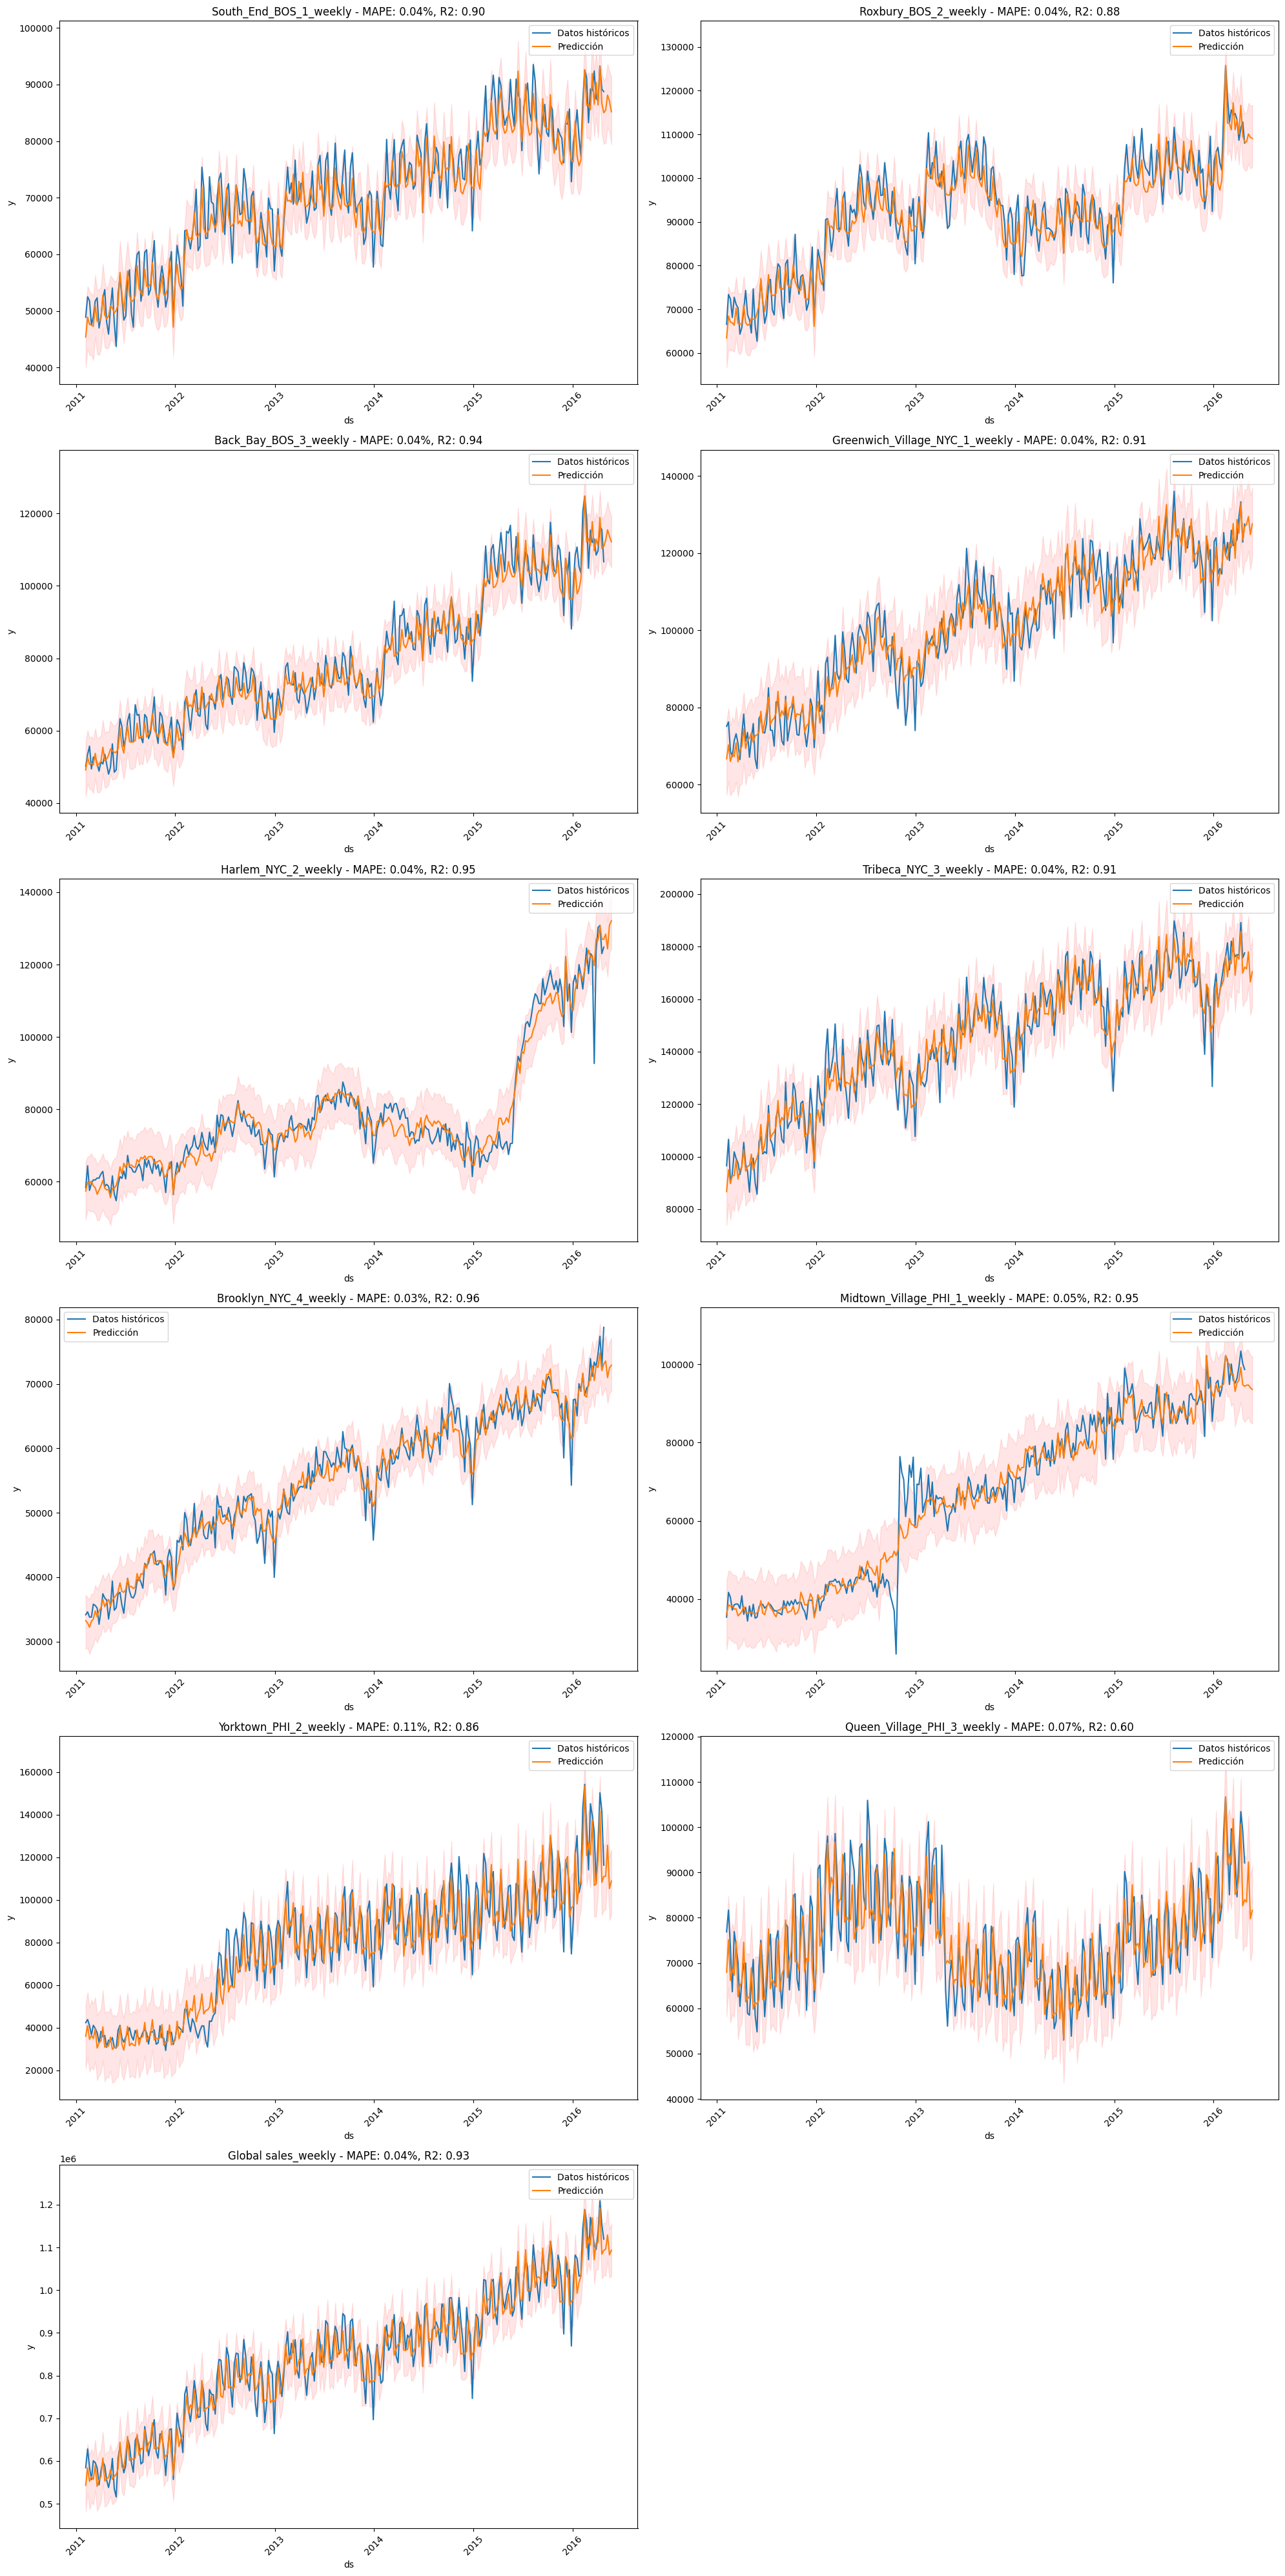

In [30]:
nueva_prediccion= prophet_store_prediction(dict_tienda_weekly_regg, df_events, 4)

## 4.2 Ajuste de hiperparametros
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Como hemos expliado anteriormente usaremos skopt para ajustar los mejores parametros. La optimizacion bayesiana que utiliza skopt nos ayuda a inteligententemente ir ajustando los parametros, aprendiendo de cada prueba para hacer mejores suposiciones sobre dónde encontrar la configuración óptima, todo esto con el objetivo de ahorrar tiempo y esfuerzo, y encontrar la mejor configuración con menos intentos.

En cuanto a la estrategia de qué datos usaremos, tomaremos la tienda de ejmplo de BOS_1, los datos son similares pero no identicos al resto por lo que nos podrá valer. Otra aproximación seria ajustar cada modelo los hiperparametros mejor a dicho modelo pero correriamos el riesgo de caer en sobreajuste y que el modelo no generalice bien.

In [31]:
# Definición del espacio de búsqueda de hiperparámetros
space = [
    Integer(10, 30, name='n_changepoints'),
    Real(0.001, 0.5, name='changepoint_prior_scale'),
    Real(0.01, 20.0, name='seasonality_prior_scale'),
    Real(0.01, 10.0, name='holidays_prior_scale'),
    Categorical(['additive', 'multiplicative'], name='seasonality_mode'),
    Real(0.8, 0.95, name='changepoint_range'),
]

# Definición de la función objetivo para optimización
@use_named_args(space)
def objective(**params):
    m = Prophet(**params, holidays=df_events)  # Añadir eventos importantes
    m.add_country_holidays(country_name='US')  # Añadir vacaciones por país
    for reg in ['week_near_15', 'second_week', 'third_week']:  # Añadir regresores especificados
        m.add_regressor(reg)
    m.fit(df_prophet_week_BOS_1_South_End)  # Ajustar modelo
    df_cv = cross_validation(m, initial='380 days', period='180 days', horizon= '60 days')
    df_p = performance_metrics(df_cv)
    return df_p['mape'].mean()  # Uso de MAPE como métrica de rendimiento



In [32]:

# Ejecuta la optimización bayesiana

# la funcion de skopt que lo gestiona es gp_minimize

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:\n")
best_params = {dim.name: res_gp.x[i] for i, dim in enumerate(space)}
for param, value in best_params.items():
    print(f"{param}: {value}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/v6ozfa0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/z7839mld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77972', 'data', 'file=/tmp/tmpxxnatxx7/v6ozfa0u.json', 'init=/tmp/tmpxxnatxx7/z7839mld.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelrtg6y6mi/prophet_model-20240416172640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:26:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 9 forecasts with cut

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mtmgzhal.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xoy_2ayt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92611', 'data', 'file=/tmp/tmpxxnatxx7/mtmgzhal.json', 'init=/tmp/tmpxxnatxx7/xoy_2ayt.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelh7akb7ac/prophet_model-20240416172640.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:26:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ltik8idp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/akxckub_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/rgr5_fxe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qtmuhi_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14869', 'data', 'file=/tmp/tmpxxnatxx7/rgr5_fxe.json', 'init=/tmp/tmpxxnatxx7/qtmuhi_l.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modell5youu1g/prophet_model-20240416172646.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/n7ahgljy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/jz79k7o4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/czp12yr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2ae9y5ua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41070', 'data', 'file=/tmp/tmpxxnatxx7/czp12yr8.json', 'init=/tmp/tmpxxnatxx7/2ae9y5ua.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelp2ep1ztg/prophet_model-20240416172652.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xisaixaj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/n41rhpjk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/itwzzv26.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/g9i3y10y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28665', 'data', 'file=/tmp/tmpxxnatxx7/itwzzv26.json', 'init=/tmp/tmpxxnatxx7/g9i3y10y.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelr1ipsd3z/prophet_model-20240416172657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:26:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:26:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/thr7ja8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/wvn9wx4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xhw7_zpu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/hb9xq9c8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90544', 'data', 'file=/tmp/tmpxxnatxx7/xhw7_zpu.json', 'init=/tmp/tmpxxnatxx7/hb9xq9c8.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modely1njd3jh/prophet_model-20240416172703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/a4h4p9x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/x1rl67ai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/36ugi200.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/n32axy2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15157', 'data', 'file=/tmp/tmpxxnatxx7/36ugi200.json', 'init=/tmp/tmpxxnatxx7/n32axy2o.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelb5raj1y_/prophet_model-20240416172709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/d8q0enk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1peig8kj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ll1h2xnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8x8afx3r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1795', 'data', 'file=/tmp/tmpxxnatxx7/ll1h2xnn.json', 'init=/tmp/tmpxxnatxx7/8x8afx3r.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model9425624k/prophet_model-20240416172715.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/o06cqto_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/zh9ibw26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qbbdx3bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/by0xrvu3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89258', 'data', 'file=/tmp/tmpxxnatxx7/qbbdx3bt.json', 'init=/tmp/tmpxxnatxx7/by0xrvu3.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelxb55t5xv/prophet_model-20240416172720.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/emenq5sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/a_ar4hj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/w8th1jrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3b_gnpta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20157', 'data', 'file=/tmp/tmpxxnatxx7/w8th1jrg.json', 'init=/tmp/tmpxxnatxx7/3b_gnpta.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelnunr0ame/prophet_model-20240416172726.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/x7wlpjsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/tmnrq8sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/7_zysre_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/c9gk5ao2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91049', 'data', 'file=/tmp/tmpxxnatxx7/7_zysre_.json', 'init=/tmp/tmpxxnatxx7/c9gk5ao2.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeli6_60b86/prophet_model-20240416172732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/yju2hxx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/wywdhozj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/v3jk734a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/tpzh5457.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3399', 'data', 'file=/tmp/tmpxxnatxx7/v3jk734a.json', 'init=/tmp/tmpxxnatxx7/tpzh5457.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelwuo0xcoi/prophet_model-20240416172738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5b27auh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/43vhrp2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mx6uo80m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/lwd9xf9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43397', 'data', 'file=/tmp/tmpxxnatxx7/mx6uo80m.json', 'init=/tmp/tmpxxnatxx7/lwd9xf9f.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelt2026589/prophet_model-20240416172746.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kb5qzldn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/rtbf9tg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/u18t4o1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/117pb5mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74834', 'data', 'file=/tmp/tmpxxnatxx7/u18t4o1r.json', 'init=/tmp/tmpxxnatxx7/117pb5mr.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelrrnk90jd/prophet_model-20240416172752.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/dgj0thph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/zagb1r89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/m08jxkp2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xtg17txi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64496', 'data', 'file=/tmp/tmpxxnatxx7/m08jxkp2.json', 'init=/tmp/tmpxxnatxx7/xtg17txi.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model48o94dl0/prophet_model-20240416172757.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/87bdpyul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/o1_0zunr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/y55w026m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/scfp5vjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70109', 'data', 'file=/tmp/tmpxxnatxx7/y55w026m.json', 'init=/tmp/tmpxxnatxx7/scfp5vjr.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelolh58x1v/prophet_model-20240416172802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/9j037w3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/yiigbevz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/w4awrhu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ovd4mnh9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24994', 'data', 'file=/tmp/tmpxxnatxx7/w4awrhu_.json', 'init=/tmp/tmpxxnatxx7/ovd4mnh9.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeltgmpihux/prophet_model-20240416172809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/lbatnsih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mwoi8mpg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/f5xtl9om.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_q0imc64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97582', 'data', 'file=/tmp/tmpxxnatxx7/f5xtl9om.json', 'init=/tmp/tmpxxnatxx7/_q0imc64.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelbzwxqo96/prophet_model-20240416172816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/d589oawj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xi1gfgu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/udqx2r05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xccovl14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75619', 'data', 'file=/tmp/tmpxxnatxx7/udqx2r05.json', 'init=/tmp/tmpxxnatxx7/xccovl14.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelp3v3zxyr/prophet_model-20240416172822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_7hz535z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gjz23ef9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/anubql8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/00fedp03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57790', 'data', 'file=/tmp/tmpxxnatxx7/anubql8a.json', 'init=/tmp/tmpxxnatxx7/00fedp03.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model4rzisbjf/prophet_model-20240416172831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ff2ekqjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6ub6oi12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/w62evwv1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/lwsya7rl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71144', 'data', 'file=/tmp/tmpxxnatxx7/w62evwv1.json', 'init=/tmp/tmpxxnatxx7/lwsya7rl.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model_y3xwlmx/prophet_model-20240416172837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/t6evn9lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/87l2qc2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/zawb_n6l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/rwc25qab.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18701', 'data', 'file=/tmp/tmpxxnatxx7/zawb_n6l.json', 'init=/tmp/tmpxxnatxx7/rwc25qab.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model4nkb702g/prophet_model-20240416172844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/w268akvv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/0nucnzjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/f7t_fj0c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ze96dka0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39793', 'data', 'file=/tmp/tmpxxnatxx7/f7t_fj0c.json', 'init=/tmp/tmpxxnatxx7/ze96dka0.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelqrdxc5p3/prophet_model-20240416172851.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6b05x9hq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/lfqaa2t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/s9lpisma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kneo8xtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92956', 'data', 'file=/tmp/tmpxxnatxx7/s9lpisma.json', 'init=/tmp/tmpxxnatxx7/kneo8xtj.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model9h9c5ogr/prophet_model-20240416172857.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:28:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:28:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3cg08tnx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3pnk_5x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_lq03f5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gjuaexog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84930', 'data', 'file=/tmp/tmpxxnatxx7/_lq03f5g.json', 'init=/tmp/tmpxxnatxx7/gjuaexog.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeldu60yofk/prophet_model-20240416172903.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8izjhorc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/77w9dk98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_6dkiwge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/10ehp39d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83688', 'data', 'file=/tmp/tmpxxnatxx7/_6dkiwge.json', 'init=/tmp/tmpxxnatxx7/10ehp39d.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model1w5oh8u9/prophet_model-20240416172911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xl1kjo6j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/nnnefo2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/iod4hn8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pomsi9dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85479', 'data', 'file=/tmp/tmpxxnatxx7/iod4hn8s.json', 'init=/tmp/tmpxxnatxx7/pomsi9dq.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelo8vbpa34/prophet_model-20240416172917.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ki87qdxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/q78ncfl3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/aikqdosa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/wvt2mkdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34444', 'data', 'file=/tmp/tmpxxnatxx7/aikqdosa.json', 'init=/tmp/tmpxxnatxx7/wvt2mkdp.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model28p79slj/prophet_model-20240416172925.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xj30inj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/j_g155pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pn36y2cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/iydhatjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13456', 'data', 'file=/tmp/tmpxxnatxx7/pn36y2cc.json', 'init=/tmp/tmpxxnatxx7/iydhatjz.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelwusmycd0/prophet_model-20240416172932.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pnfjzwes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ru72p_mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vp4dcxis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/zx9ne77c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64845', 'data', 'file=/tmp/tmpxxnatxx7/vp4dcxis.json', 'init=/tmp/tmpxxnatxx7/zx9ne77c.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelarbebmtl/prophet_model-20240416172940.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/fe9ptin6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xop0pb79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gp9jjtwq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kj77n6lg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29201', 'data', 'file=/tmp/tmpxxnatxx7/gp9jjtwq.json', 'init=/tmp/tmpxxnatxx7/kj77n6lg.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelhsltf6c5/prophet_model-20240416172945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/23h0fn27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/v8tyz7bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kpipct9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6seain06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49522', 'data', 'file=/tmp/tmpxxnatxx7/kpipct9h.json', 'init=/tmp/tmpxxnatxx7/6seain06.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelcatu5ou1/prophet_model-20240416172953.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:29:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/cs3rbxjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/4jqskmh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8th50bzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/llwmoqoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25833', 'data', 'file=/tmp/tmpxxnatxx7/8th50bzq.json', 'init=/tmp/tmpxxnatxx7/llwmoqoq.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelldwv17z0/prophet_model-20240416173001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/w9hl7r0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/iihat1ky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/d2qbam7g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/k8r768tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34360', 'data', 'file=/tmp/tmpxxnatxx7/d2qbam7g.json', 'init=/tmp/tmpxxnatxx7/k8r768tq.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model1urvg7hd/prophet_model-20240416173009.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mscsbgeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_9opqxcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pdr6lq4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gq1gamch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38170', 'data', 'file=/tmp/tmpxxnatxx7/pdr6lq4q.json', 'init=/tmp/tmpxxnatxx7/gq1gamch.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelbvd_ewia/prophet_model-20240416173017.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/spujp8s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/p_de0svw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1finvsfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/g3mgndw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6834', 'data', 'file=/tmp/tmpxxnatxx7/1finvsfz.json', 'init=/tmp/tmpxxnatxx7/g3mgndw2.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelh9j09o69/prophet_model-20240416173024.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/tp6gzofp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/dy4condg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/jbjt1gul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/dg_6rkcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24440', 'data', 'file=/tmp/tmpxxnatxx7/jbjt1gul.json', 'init=/tmp/tmpxxnatxx7/dg_6rkcy.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeluzmj18qc/prophet_model-20240416173031.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8bosdh5q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vikxym3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vkgkj9ov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/bz1dpztx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7640', 'data', 'file=/tmp/tmpxxnatxx7/vkgkj9ov.json', 'init=/tmp/tmpxxnatxx7/bz1dpztx.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelzsynyz9u/prophet_model-20240416173037.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2h_xnefn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8qr_mvz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/btvwsae4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/msw69h6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82073', 'data', 'file=/tmp/tmpxxnatxx7/btvwsae4.json', 'init=/tmp/tmpxxnatxx7/msw69h6y.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelbgea4vc4/prophet_model-20240416173043.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1pjiaj1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/c2yh1fjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/guyk9joe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5tirbx12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78915', 'data', 'file=/tmp/tmpxxnatxx7/guyk9joe.json', 'init=/tmp/tmpxxnatxx7/5tirbx12.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelb0af48gw/prophet_model-20240416173050.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/c2yjtian.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gehxxm1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/p_nf535i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_k7kqdf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65486', 'data', 'file=/tmp/tmpxxnatxx7/p_nf535i.json', 'init=/tmp/tmpxxnatxx7/_k7kqdf1.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model2sn8df7n/prophet_model-20240416173059.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:30:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/p7wfop9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/4aajgey6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/20g5p4j7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/e6sxxdoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66378', 'data', 'file=/tmp/tmpxxnatxx7/20g5p4j7.json', 'init=/tmp/tmpxxnatxx7/e6sxxdoz.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelrjs9wc7a/prophet_model-20240416173107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ho85k7vj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8zh9z8_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/my0rngqu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/i3_mfig4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58099', 'data', 'file=/tmp/tmpxxnatxx7/my0rngqu.json', 'init=/tmp/tmpxxnatxx7/i3_mfig4.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelvsnf_y4l/prophet_model-20240416173115.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/76qcv3j1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_tr5gvh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6vmvkmlf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/o0gt6czw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8395', 'data', 'file=/tmp/tmpxxnatxx7/6vmvkmlf.json', 'init=/tmp/tmpxxnatxx7/o0gt6czw.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelkzif1b7l/prophet_model-20240416173121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/feww1ctc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qiyyfd_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/64k2cfcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8fycnan5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30716', 'data', 'file=/tmp/tmpxxnatxx7/64k2cfcc.json', 'init=/tmp/tmpxxnatxx7/8fycnan5.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model3wr7immp/prophet_model-20240416173129.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/4f6gzpjh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/yeu8tmv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/erh9xdup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/n2zwwmi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23021', 'data', 'file=/tmp/tmpxxnatxx7/erh9xdup.json', 'init=/tmp/tmpxxnatxx7/n2zwwmi9.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelkokt6nz1/prophet_model-20240416173135.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/31i39rbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/094th1l7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3hy92huq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5alw4uog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20022', 'data', 'file=/tmp/tmpxxnatxx7/3hy92huq.json', 'init=/tmp/tmpxxnatxx7/5alw4uog.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model39h8fx9b/prophet_model-20240416173143.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/h7qqkhum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/4vhzk24_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gry4k_gs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/rx0nnb_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53127', 'data', 'file=/tmp/tmpxxnatxx7/gry4k_gs.json', 'init=/tmp/tmpxxnatxx7/rx0nnb_x.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model8r3a_y62/prophet_model-20240416173149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/633vks0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/fm_k41vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/wdj_v58o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1v8nlnn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1481', 'data', 'file=/tmp/tmpxxnatxx7/wdj_v58o.json', 'init=/tmp/tmpxxnatxx7/1v8nlnn5.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model4_ehdw84/prophet_model-20240416173158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:31:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xecjbun3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/x8juskiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/idf_ge5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/edxsdgmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72404', 'data', 'file=/tmp/tmpxxnatxx7/idf_ge5m.json', 'init=/tmp/tmpxxnatxx7/edxsdgmr.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modell9rrv9vj/prophet_model-20240416173206.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/wdcxcxtc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/7tw6etp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/0bhydf6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/famdvqq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58723', 'data', 'file=/tmp/tmpxxnatxx7/0bhydf6d.json', 'init=/tmp/tmpxxnatxx7/famdvqq3.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelb2vlj3v7/prophet_model-20240416173214.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2cvf88dv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vax9klef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

Mejores hiperparámetros encontrados:

n_changepoints: 12
changepoint_prior_scale: 0.48493472480562777
seasonality_prior_scale: 13.066269315600774
holidays_prior_scale: 1.7173867555090914
seasonality_mode: additive
changepoint_range: 0.9126029211827684


In [33]:
# Obtenemos los mejores hiperparametros para nuestro modelo.
best_params

{'n_changepoints': 12,
 'changepoint_prior_scale': 0.48493472480562777,
 'seasonality_prior_scale': 13.066269315600774,
 'holidays_prior_scale': 1.7173867555090914,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.9126029211827684}

## 4.3 Cross-Validation
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

La Cross-Validation nos permitirá aumentar la robusted de nuestro modelo. En otros modelos de clasificacion la estrategia de validacion es distinta a las series temporales, en éstas la validacion se hace aumentando el periodo ventana cada vez que se entrena (rolling-window).

En este caso no es necesario utilizar un split de train-test porque incorporamos validacion cruzada al conjunto.

In [34]:
# utilizamos la misma funcion anterior pero añadiendo los mejores parametros encontrados y la cross-validation

def prophet_store_prediction_final(dict_tienda, df_events, periods_weeks, best_params):
    # Configurar el tamaño de la figura para los subplots
    plt.figure(figsize=(20, 40))

    # Inicializamos una lista vacía para almacenar los resultados de todas las tiendas
    todas_predicciones = []

    for idx, (nombre_tienda, df_tienda) in enumerate(dict_tienda.items()):
        # Extraemos los hiperparámetros para esta tienda
        params = best_params.get(nombre_tienda, {})

        # Ajustamos el modelo con eventos E HIPERPARAMETROS OPTIMOS
        model = Prophet( holidays= df_events, **params)

        # Añadimos las vacaciones de dicho pais
        model.add_country_holidays(country_name='US')

        # AÑADIMOS REGRESORES CREADOS ['week_near_15', 'second_week', 'third_week']
        for reg in ['week_near_15', 'second_week', 'third_week']:
          model.add_regressor(reg)

        # hacemos el fit
        model.fit(df_tienda)

        # Realizamos la CROSS-VALIDATION fijando el horozonte de prediccion acorde a las semanas
        horizon_days= periods_weeks*7
        df_cv = cross_validation(model, initial='380 days', period='180 days', horizon=f'{horizon_days} days')
        df_p = performance_metrics(df_cv)
        mape = df_p['mape'].mean()
        print(f'MAPE para {nombre_tienda}: {mape}')

        # Predecimos el futuro
        future = model.make_future_dataframe(periods=periods_weeks, freq='W')
        # importante añadimos columna nueva DEL REGRESOR
        future['week_near_15'] = future['ds'].apply(lambda x: 1 if (10 <= x.day <= 20) else 0)
        future['second_week'] = future['ds'].apply(lambda x: 1 if (8 <= x.day <= 14) else 0)
        future['third_week'] = future['ds'].apply(lambda x: 1 if (15 <= x.day <= 21) else 0)


        forecast = model.predict(future)

        # Seleccionamos el subplot adecuado
        ax = plt.subplot(6, 2, idx + 1)

        # Visualizamos los datos históricos y las predicciones
        sns.lineplot(data=df_tienda, x='ds', y='y', label='Datos históricos', ax=ax)
        sns.lineplot(data=forecast, x='ds', y='yhat', label='Predicción', ax=ax)

        # Añadimos los intervalos de confianza
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Intervalo de confianza')

        # Agregar las predicciones a la lista
        forecast['store'] = nombre_tienda
        forecast = forecast[['ds', 'store', 'yhat', 'trend', 'yhat_lower', 'yhat_upper']]
        forecast['y'] = df_tienda.set_index('ds').reindex(forecast.set_index('ds').index)['y'].reset_index(drop=True)
        todas_predicciones.append(forecast)


        # Limitamos el cálculo del MAPE y R2 solo a las fechas históricas
        forecasted = forecast[['ds', 'yhat']].merge(df_tienda, on='ds', how='right')
        y_true = df_tienda['y']
        y_pred = forecasted['yhat']


        # Calculamos el MAPE y R2
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Título del subplot
        plt.title(f'{nombre_tienda} - MAPE: {mape:.2f}%, R2: {r2:.2f}')
        # Rotar las etiquetas del eje X para mejor lectura

        plt.xticks(rotation=45)



    plt.tight_layout()
    plt.show()

    # Concatenar todas las predicciones en un único DataFrame
    df_predicciones_prophet = pd.concat(todas_predicciones, ignore_index=True)

    return df_predicciones_prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/i0ovrkje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1ko3h3dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53932', 'data', 'file=/tmp/tmpxxnatxx7/i0ovrkje.json', 'init=/tmp/tmpxxnatxx7/1ko3h3dq.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelyk4scxgd/prophet_model-20240416173221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3erjyrvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ex34ghak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61669', 'data', 'file=/tmp/tmpxxnatxx7/3erjyrvr.json', 'init=/tmp/tmpxxnatxx7/ex34ghak.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model_epf6trm/prophet_model-20240416173221.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/zoakvwjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kxx7o9vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para South_End_BOS_1_weekly: 0.04996526331876985


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/y0pxu6am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/7uas5epd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27774', 'data', 'file=/tmp/tmpxxnatxx7/y0pxu6am.json', 'init=/tmp/tmpxxnatxx7/7uas5epd.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelrgvzjh17/prophet_model-20240416173228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/e174bnwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mw6_0g5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27979', 'data', 'file=/tmp/tmpxxnatxx7/e174bnwd.json', 'init=/tmp/tmpxxnatxx7/mw6_0g5z.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelcd4soghi/prophet_model-20240416173229.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/njbswduf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/kotl43hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Roxbury_BOS_2_weekly: 0.07576242711061658


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2gm6dcnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pseij8ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15993', 'data', 'file=/tmp/tmpxxnatxx7/2gm6dcnf.json', 'init=/tmp/tmpxxnatxx7/pseij8ek.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelimf2pagy/prophet_model-20240416173234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/udz2zfku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/0391g4ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71980', 'data', 'file=/tmp/tmpxxnatxx7/udz2zfku.json', 'init=/tmp/tmpxxnatxx7/0391g4ke.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model9nqtmaa6/prophet_model-20240416173234.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1vmp23q6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/rweoi3xq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Back_Bay_BOS_3_weekly: 0.05868993424192033


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/lsfdjxn3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/g6cn1ai9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65', 'data', 'file=/tmp/tmpxxnatxx7/lsfdjxn3.json', 'init=/tmp/tmpxxnatxx7/g6cn1ai9.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model9dr5mvbk/prophet_model-20240416173240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutoff

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/mgdyqfod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vfgxvgve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85266', 'data', 'file=/tmp/tmpxxnatxx7/mgdyqfod.json', 'init=/tmp/tmpxxnatxx7/vfgxvgve.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model5j0sb1w4/prophet_model-20240416173241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qqylxhbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/cvzf_bi4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Greenwich_Village_NYC_1_weekly: 0.06661418551631378


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2w_m40gj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/opak8g4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58714', 'data', 'file=/tmp/tmpxxnatxx7/2w_m40gj.json', 'init=/tmp/tmpxxnatxx7/opak8g4w.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeltyog0dpz/prophet_model-20240416173246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/risc7py3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/1xcgdt68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61050', 'data', 'file=/tmp/tmpxxnatxx7/risc7py3.json', 'init=/tmp/tmpxxnatxx7/1xcgdt68.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelq71qidbc/prophet_model-20240416173246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/f360ivgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/v7pd48bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Harlem_NYC_2_weekly: 0.10443435990556296


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ed012y3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/21yyynpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31860', 'data', 'file=/tmp/tmpxxnatxx7/ed012y3g.json', 'init=/tmp/tmpxxnatxx7/21yyynpj.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelpyr4z244/prophet_model-20240416173251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/llnel0ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6k3l9_r2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70638', 'data', 'file=/tmp/tmpxxnatxx7/llnel0ng.json', 'init=/tmp/tmpxxnatxx7/6k3l9_r2.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelciq_78w9/prophet_model-20240416173252.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/8m14v2xc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/vn1elqv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Tribeca_NYC_3_weekly: 0.05984768322237786


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/me36w7wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/6ruhjju7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89313', 'data', 'file=/tmp/tmpxxnatxx7/me36w7wn.json', 'init=/tmp/tmpxxnatxx7/6ruhjju7.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelg7h9r78x/prophet_model-20240416173258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/pnhdxy4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/bo6gixw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34134', 'data', 'file=/tmp/tmpxxnatxx7/pnhdxy4u.json', 'init=/tmp/tmpxxnatxx7/bo6gixw4.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model28zf7h4w/prophet_model-20240416173258.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/nwqs11wj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/2vf_scfb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Brooklyn_NYC_4_weekly: 0.05044208054510403


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/21zoq50x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/uemgv5oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32305', 'data', 'file=/tmp/tmpxxnatxx7/21zoq50x.json', 'init=/tmp/tmpxxnatxx7/uemgv5oo.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modeln1ov4i2r/prophet_model-20240416173303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/nebr7y2m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gq4asn3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56734', 'data', 'file=/tmp/tmpxxnatxx7/nebr7y2m.json', 'init=/tmp/tmpxxnatxx7/gq4asn3_.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelxb_l35k8/prophet_model-20240416173303.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qdfinkzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/yns98nfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Midtown_Village_PHI_1_weekly: 0.09583378424683206


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5gze_fm8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3lzkmm5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=372', 'data', 'file=/tmp/tmpxxnatxx7/5gze_fm8.json', 'init=/tmp/tmpxxnatxx7/3lzkmm5_.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model7xre8nwc/prophet_model-20240416173310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cutof

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/xaly1ecj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qr3n5rtw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7553', 'data', 'file=/tmp/tmpxxnatxx7/xaly1ecj.json', 'init=/tmp/tmpxxnatxx7/qr3n5rtw.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_model0b8a1ptt/prophet_model-20240416173311.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:33:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/tsnf916_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/ctkpewzs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE para Yorktown_PHI_2_weekly: 0.1797557281996608


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/gm4ow3ng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/5fr7zagy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57376', 'data', 'file=/tmp/tmpxxnatxx7/gm4ow3ng.json', 'init=/tmp/tmpxxnatxx7/5fr7zagy.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelj8z24af9/prophet_model-20240416173316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/3w427byx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/msztrh22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31226', 'data', 'file=/tmp/tmpxxnatxx7/3w427byx.json', 'init=/tmp/tmpxxnatxx7/msztrh22.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelzmv0ydod/prophet_model-20240416173316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/d4ljs9_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/qy4w3_sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Queen_Village_PHI_3_weekly: 0.09521977972959157


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/omwi7eww.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/_anhtlqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98205', 'data', 'file=/tmp/tmpxxnatxx7/omwi7eww.json', 'init=/tmp/tmpxxnatxx7/_anhtlqj.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modelorxwo9g9/prophet_model-20240416173323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 8 forecasts with cut

  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/g3ncondj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/p5hofagb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93445', 'data', 'file=/tmp/tmpxxnatxx7/g3ncondj.json', 'init=/tmp/tmpxxnatxx7/p5hofagb.json', 'output', 'file=/tmp/tmpxxnatxx7/prophet_modely26v09iu/prophet_model-20240416173323.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:33:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/jxnhpmed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxxnatxx7/oojspwhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

MAPE para Global sales_weekly: 0.04341522758387228


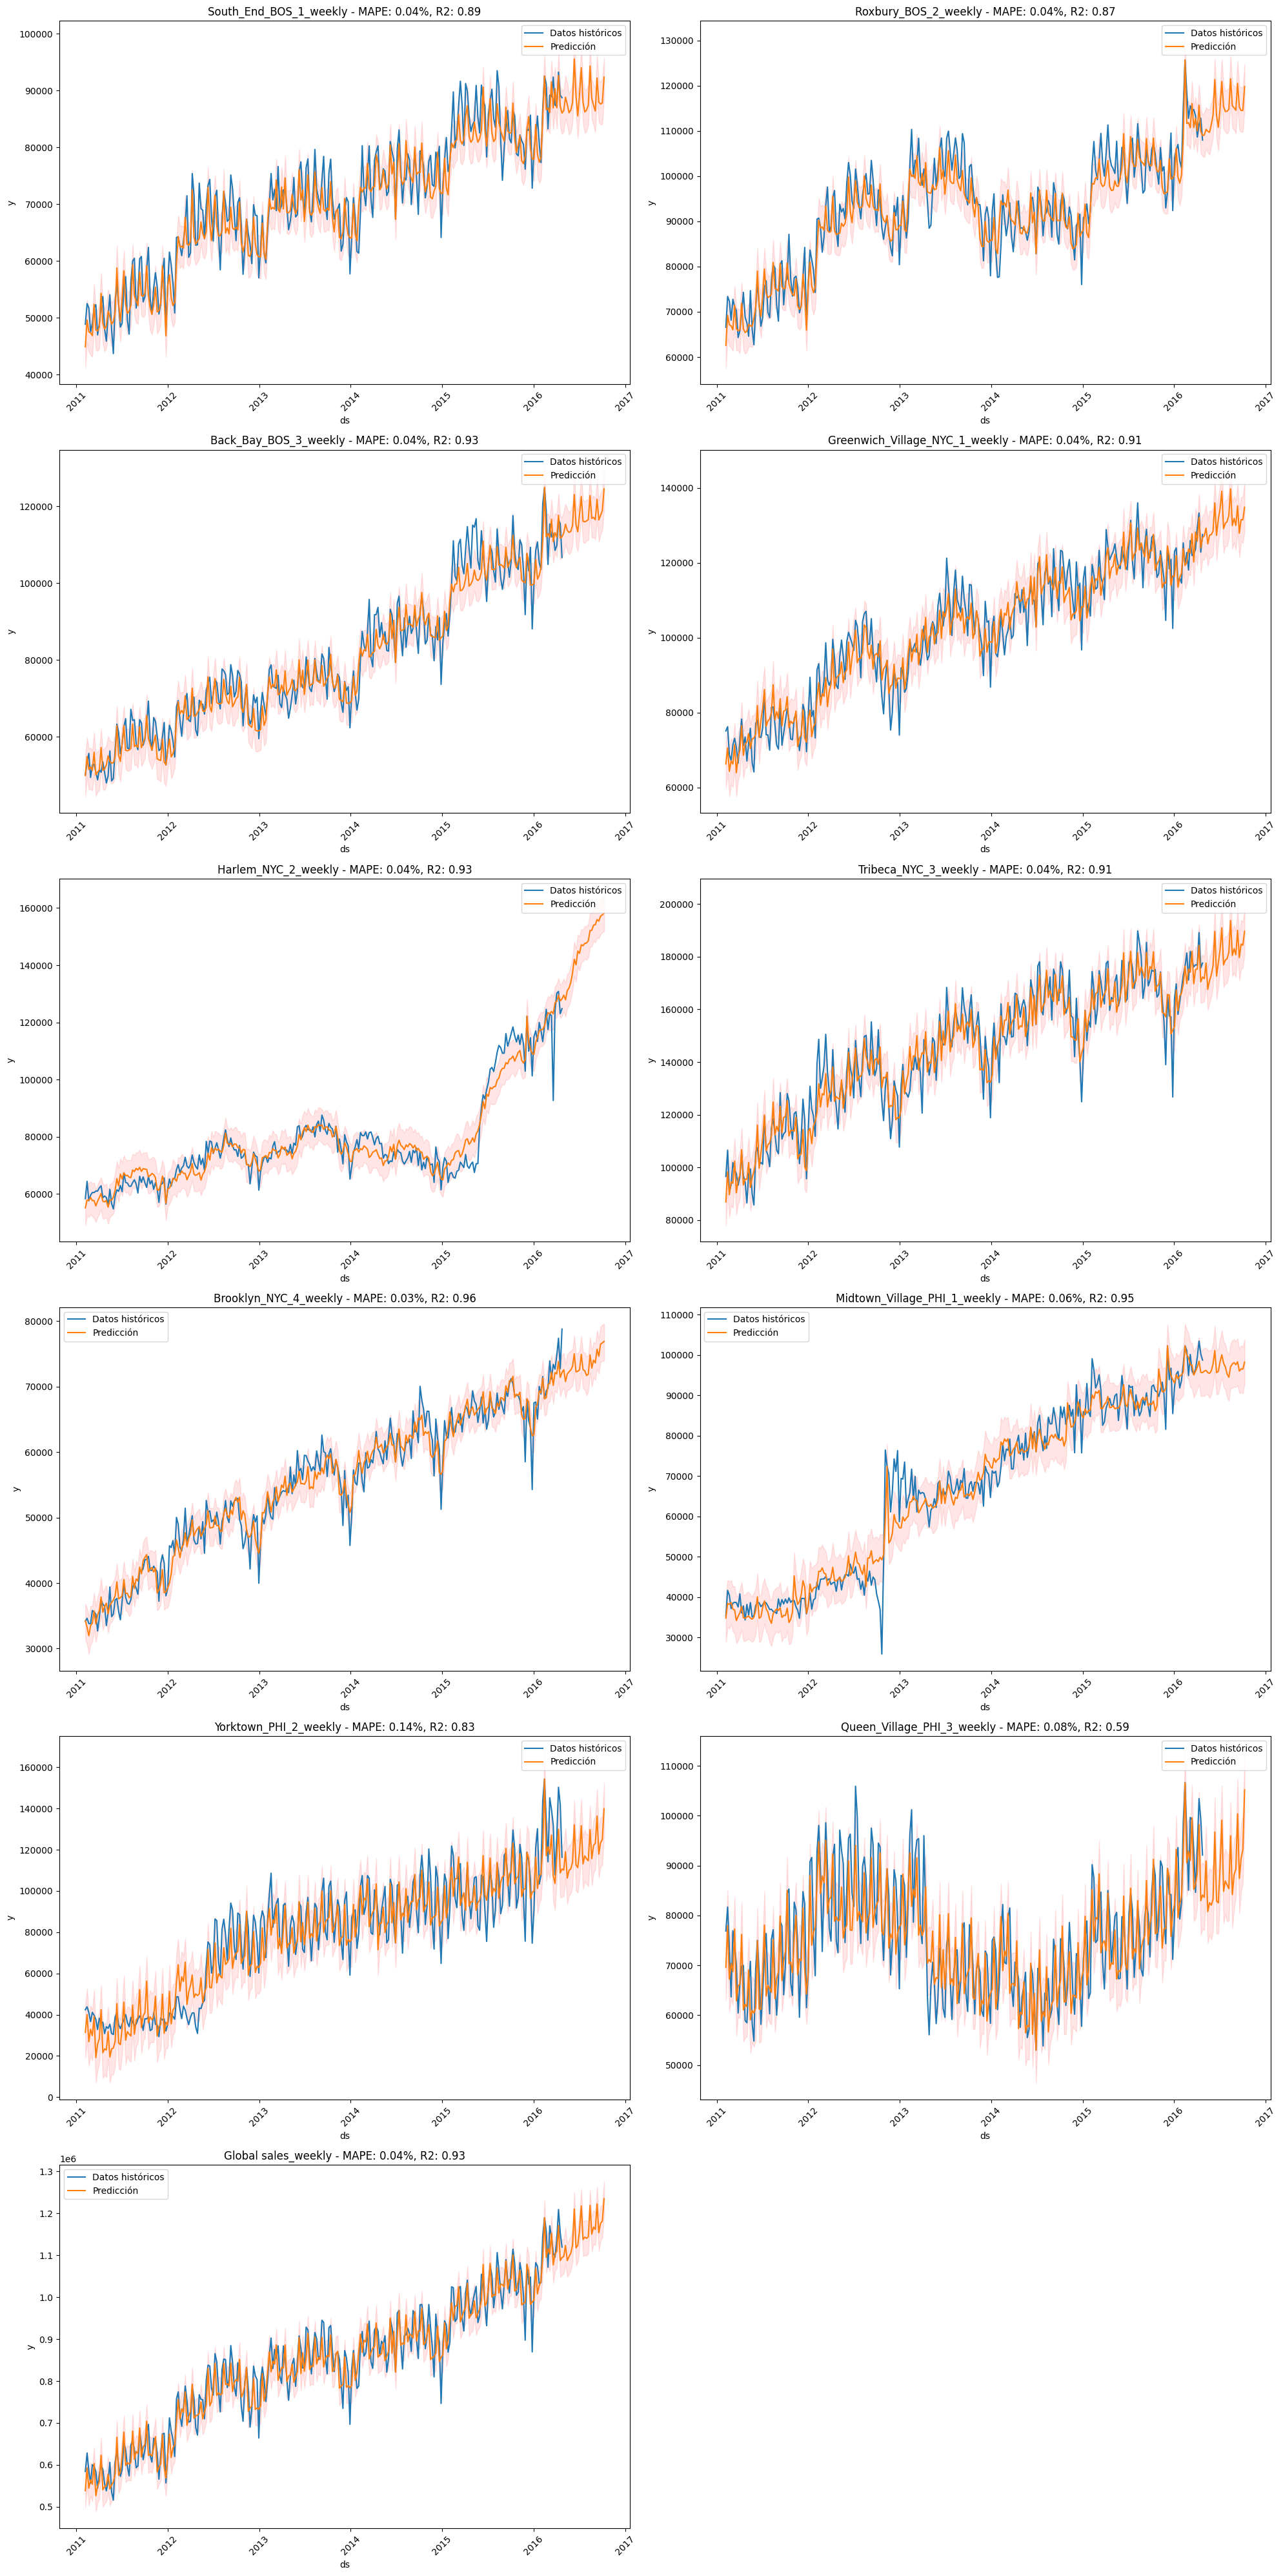

In [35]:
df_cv_hpt_prediccions= prophet_store_prediction_final(dict_tienda_weekly_regg,df_events, 24,best_params)

In [36]:
df_cv_hpt_prediccions

ds                   store          yhat         trend  \
0    2011-02-06  South_End_BOS_1_weekly  4.490508e+04  4.310246e+04   
1    2011-02-13  South_End_BOS_1_weekly  4.960609e+04  4.339624e+04   
2    2011-02-20  South_End_BOS_1_weekly  4.754302e+04  4.369002e+04   
3    2011-02-27  South_End_BOS_1_weekly  4.737124e+04  4.398380e+04   
4    2011-03-06  South_End_BOS_1_weekly  4.688595e+04  4.427758e+04   
...         ...                     ...           ...           ...   
3262 2016-09-11     Global sales_weekly  1.222182e+06  1.147178e+06   
3263 2016-09-18     Global sales_weekly  1.153802e+06  1.149784e+06   
3264 2016-09-25     Global sales_weekly  1.176349e+06  1.152390e+06   
3265 2016-10-02     Global sales_weekly  1.181103e+06  1.154996e+06   
3266 2016-10-09     Global sales_weekly  1.234707e+06  1.157602e+06   

        yhat_lower    yhat_upper           y  
0     4.124285e+04  4.884413e+04  48892.7164  
1     4.560744e+04  5.314614e+04  52513.8213  
2     4.401696e+04  5.115067e+04  51784.1312  
3     4.344861e+04  5.083744e+04  47537.8775  
4     4.316583e+04  5.051560e+04  49005.6250  
...            ...           ...         ...  
3262  1.180012e+06  1.263425e+06         NaN  
3263  1.110027e+06  1.193331e+06         NaN  
3264  1.134375e+06  1.216493e+06         NaN  
3265  1.142070e+06  1.221659e+06         NaN  
3266  1.196733e+06  1.276135e+06         NaN  

[3267 rows x 7 columns]

<a id='seccion5'></a>
# **5. Conclusiones**
<hr style="height:5px;border-width:0;color:brown;background-color:brown">

Hemos visto que el modelo ha mejorado desde que lo hemos ejecutado desde bruto hasta refinado. Experimentamos una mejora significativa de la prediccion cuando incluimos eventos significativo en el modelo. Sin embargo el efecto de las vacaciones parece no ser positivo en el modelo ya que no le permite generalizar bien (quizás por tratarse de una cadena de supermercados y los dias festivos pueden no ser tan importantes como en otros sectores).

Tras hacer la optimizacion de hiperparametros e inclusion de regresores, las predicciones mejoran muchisimo capturando los picos maximos y minimos de las ventas. Esto nos permite tener un modelo más preciso. Podremos ver estos cambios en la grafica mas abajo donde compararemos el modelo RAW respecto al hiperparametrizado

Finalmente utilizaremos los datos de prediccion a modo de rolling forecast actualizandolo a cada semana. La idea practica detras de todo esto sería montar este modelo en la nube para hacer un rolling forecast mas acertado actualizandose cada semana. De esta forma cada tienda podría prepararse de cara a un aumento considerable de tienda y stockarse de productos.



Text(0.5, 1.0, 'Model Fine Tunned South End - BOS_1 - MAPE: 0.04%, R2: 0.89')

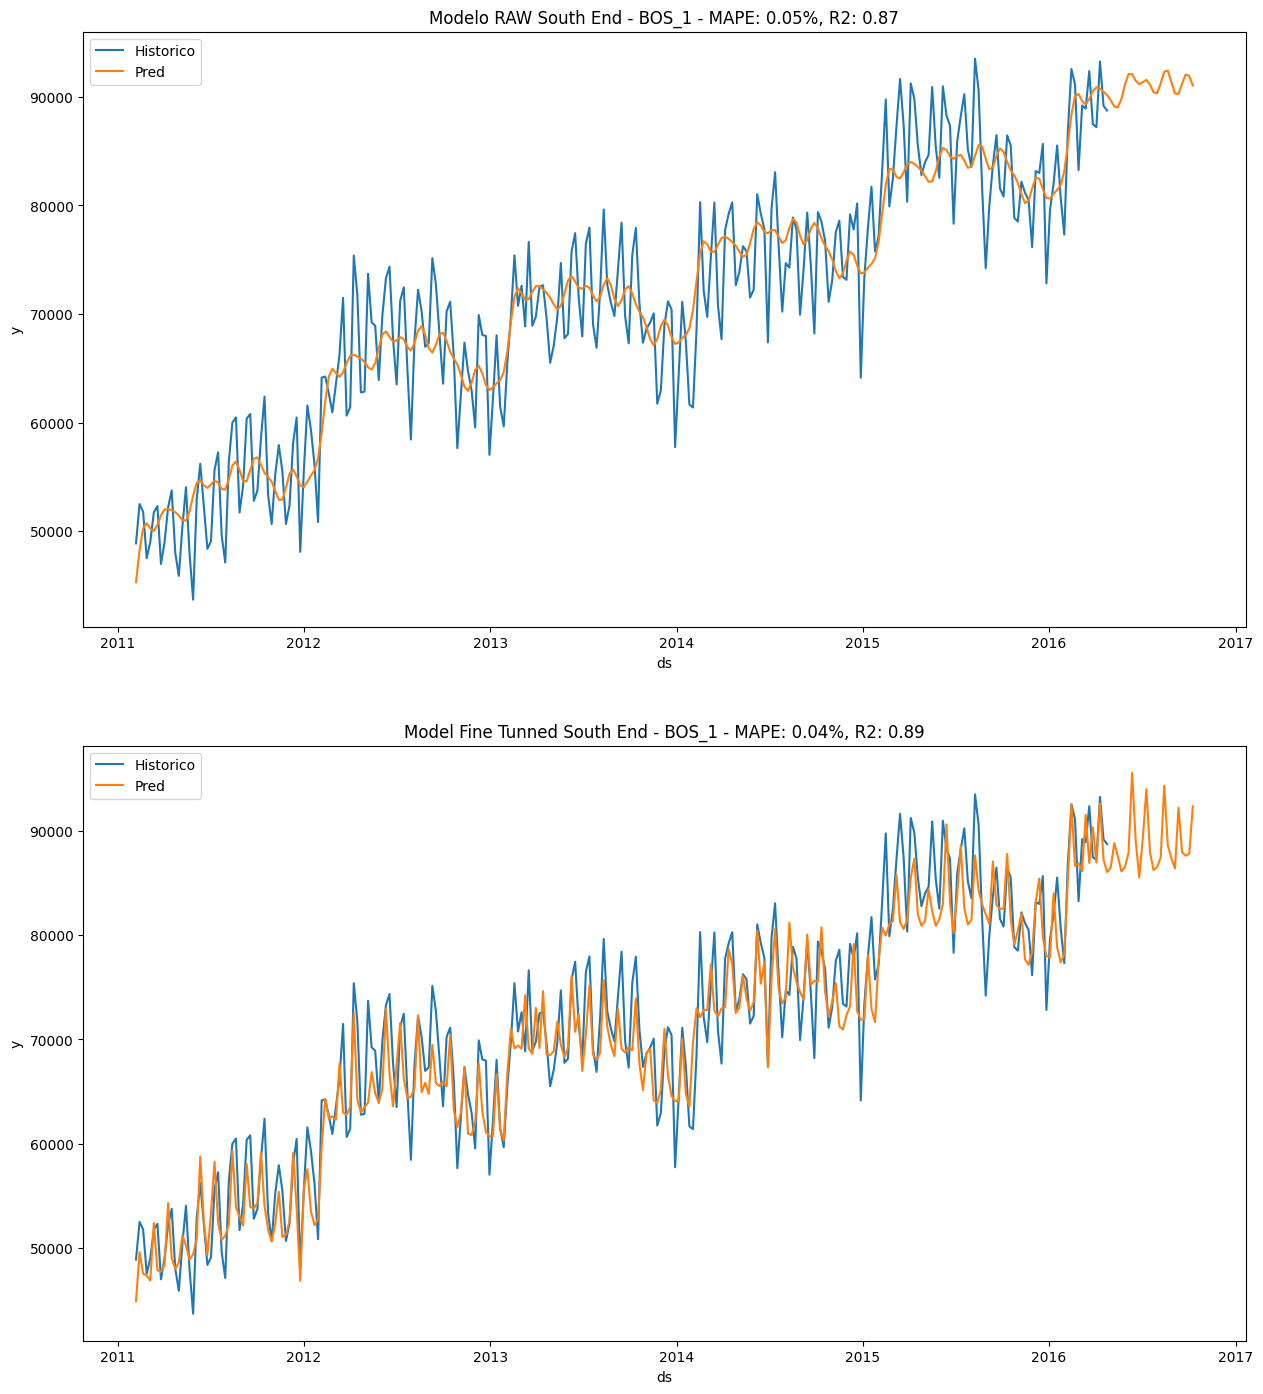

In [37]:

# Crear subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 17))


# primer grafico

sns.lineplot(data=Prophet_RAW_BOS_1_predictions,x='ds',y='y',label='Historico',ax=axes[0])
sns.lineplot(data=Prophet_RAW_BOS_1_predictions,x='ds',y='yhat',label='Pred',ax=axes[0])

# Para calcular el MAPE necesitamos filtrar la prediccion a las fechas presentes en el historico
df_RAW_BOS_1 = Prophet_RAW_BOS_1_predictions.dropna(axis=0)
y_pred = df_RAW_BOS_1['yhat']
y_true = df_RAW_BOS_1['y']

# Calculamos el MAPE y R2
mape_raw = mean_absolute_percentage_error(y_true, y_pred)
r2_raw = r2_score(y_true, y_pred)
# Añadimos el título con la tienda y metricas
axes[0].set_title(f'Modelo RAW South End - BOS_1 - MAPE: {mape_raw:.2f}%, R2: {r2_raw:.2f}')


# Segundo grafico
Prophet_Fine_tunned_BOS_1_predictions= df_cv_hpt_prediccions.query('store=="South_End_BOS_1_weekly"')

sns.lineplot(data=Prophet_Fine_tunned_BOS_1_predictions,x='ds',y='y',label='Historico',ax=axes[1])
sns.lineplot(data=Prophet_Fine_tunned_BOS_1_predictions,x='ds',y='yhat',label='Pred',ax=axes[1])

# Para calcular el MAPE necesitamos filtrar la prediccion a las fechas presentes en el historico
df_fine_tunned = Prophet_Fine_tunned_BOS_1_predictions.dropna(axis=0)
y_pred = df_fine_tunned['yhat']
y_true = df_fine_tunned['y']

# Calculamos el MAPE y R2
mape_ft = mean_absolute_percentage_error(y_true, y_pred)
r2_ft = r2_score(y_true, y_pred)
# Añadimos el título con la tienda y metricas
axes[1].set_title(f'Model Fine Tunned South End - BOS_1 - MAPE: {mape_ft:.2f}%, R2: {r2_ft:.2f}')




<a id='seccion6'></a>
# **6. Aplicacion practica prediccion modelo**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Una vez que tenemos las predicciones a nivel semanal, iremos cruzando los datos que generan los modelos (ventas por tienda por semana) con la proporcion de productos que se venden usualmente durante esa semana por tienda, obteniendo así el valor esperado por producto y desde aqui afinar mas a prediccion por unidades de producto por tienda en una semana determinada.

In [39]:
# importamos el csv donde se encuentran los datos desde los que extrapolar las predicciones del modelo.

df_perc_product = pd.read_csv('mask_product_store_by_week.csv',index_col=0)
df_perc_product

store                 item  week  total_sales  sales_pct  \
0        Back_Bay_BOS_3     ACCESORIES_1_001   1.0      66.0744   0.015892   
1        Back_Bay_BOS_3     ACCESORIES_1_001   2.0      88.3652   0.021254   
2        Back_Bay_BOS_3     ACCESORIES_1_001   3.0      88.0460   0.021177   
3        Back_Bay_BOS_3     ACCESORIES_1_001   4.0      65.9148   0.015854   
4        Back_Bay_BOS_3     ACCESORIES_1_001   5.0     132.4680   0.031861   
...                 ...                  ...   ...          ...        ...   
1313131   Tribeca_NYC_3  HOME_&_GARDEN_1_382  16.0      82.6500   0.027384   
1313132   Tribeca_NYC_3  HOME_&_GARDEN_1_382  17.0      57.0000   0.018886   
1313133   Tribeca_NYC_3  HOME_&_GARDEN_1_382  18.0      25.6500   0.008499   
1313134   Tribeca_NYC_3  HOME_&_GARDEN_1_382  19.0      34.2000   0.011331   
1313135   Tribeca_NYC_3  HOME_&_GARDEN_1_382  20.0      22.8000   0.007554   

         price_mean  
0            0.6251  
1            0.6251  
2            0.6251  
3            0.6251  
4            0.6251  
...             ...  
1313131      1.7256  
1313132      1.7256  
1313133      1.7256  
1313134      1.7256  
1313135         NaN  

[1313136 rows x 6 columns]

In [40]:
df_perc_product.isna().sum()

store          0
item           0
week           0
total_sales    0
sales_pct      0
price_mean     1
dtype: int64